In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from src.models import TranAD, iTransformer
import torch

In [2]:
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', ['#17becf','#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.style.use([hep.style.ROOT, hep.style.firamath])
# plt.rcParams['lines.markersize'] = 5
# plt.rcParams['lines.linewidth'] = 3

### for first studies on importance of q and n_window

In [ ]:
iTransf_n_windows = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500, 1000, 2000]
TranAD_n_windows = [10, 20, 30, 40, 50, 60, 70]

iTransf_q =  [0.5, 0.25, 0.1, 0.075, 0.05, 1e-2, 1e-3, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 1e-7]
TranAD_q = [0.5, 0.25, 0.1, 0.075, 0.05, 1e-2, 1e-3, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 1e-7]

In [ ]:
N = 25
dataset = 'SMAP_new'
less = False
plot_path = './studies2.3/plots'
studies_path = './studies2.3'

In [ ]:
loader = []
for file in ['train', 'test', 'labels']:
    if dataset == 'SMD': file = 'machine-1-1_' + file
    if dataset == 'SMAP': file = 'P-1_' + file
    if dataset == 'SMAP_new': file = 'P-1_' + file
    if dataset == 'MSL': file = 'C-1_' + file
    if dataset == 'MSL_new': file = 'C-1_' + file
    if dataset == 'UCR': file = '136_' + file
    if dataset == 'NAB': file = 'ec2_request_latency_system_failure_' + file
    loader.append(np.load(os.path.join(f'processed/{dataset}', f'{file}.npy')))
train_data = loader[0]
test_data = loader[1]
true_labels = loader[2]
print(train_data, train_data[0].shape, train_data.shape)
print(test_data, test_data[0].shape)

In [ ]:
TranAD_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
TranAD_labels = []
loss = np.zeros((len(TranAD_n_windows), N))

print(loss.shape, loss[0].shape)
for i, elem in enumerate(TranAD_n_windows):
    path = f'{studies_path}/TranAD_{dataset}_2/n_window{elem}/results'
    model_path = f'{studies_path}/n_window{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = TranAD(N, elem).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    TranAD_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    TranAD_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    TranAD_all_res['f1'].append(df_res['f1'])
    TranAD_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    TranAD_labels.append(np.array(df_labels))
TranAD_all_res['loss'] = loss
print(TranAD_labels[0].shape, len(TranAD_labels))
# print(TranAD_all_res)

In [ ]:
iTransf_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
loss = np.zeros((len(iTransf_n_windows), N))
iTransf_labels = []

for i, elem in enumerate(iTransf_n_windows):
    path = f'{studies_path}/iTransformer_{dataset}_2/n_window{elem}/results'
    model_path = f'{studies_path}/n_window{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = iTransformer(N, elem).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    iTransf_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res)
    iTransf_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    TranAD_all_res['f1'].append(df_res['f1'])
    iTransf_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    TranAD_labels.append(np.array(df_labels))
TranAD_all_res['loss'] = loss
print(iTransf_labels[0].shape, len(iTransf_labels))
# print(iTransf_all_res)

In [ ]:
# same as previous but for detection level instead of window size
iTransf_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
loss = np.zeros((len(iTransf_q), N))
iTransf_labels = []

for i, elem in enumerate(iTransf_q):
    path = f'{studies_path}/iTransformer_{dataset}/detection_lvl_{elem}/results'
    model_path = f'{studies_path}/iTransformer_{dataset}/detection_lvl_{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = iTransformer(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    iTransf_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res)
    iTransf_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    iTransf_all_res['f1'].append(df_res['f1'])
    iTransf_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    iTransf_labels.append(np.array(df_labels))
iTransf_all_res['loss'] = loss
print(iTransf_labels[0].shape, len(iTransf_labels))
# print(iTransf_all_res)

In [ ]:
# same as previous but for detection level instead of window size
TranAD_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
loss = np.zeros((len(TranAD_q), N))
TranAD_labels = []

for i, elem in enumerate(TranAD_q):
    path = f'{studies_path}/TranAD_{dataset}/detection_lvl_{elem}/results'
    model_path = f'{studies_path}/TranAD_{dataset}/detection_lvl_{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = TranAD(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    TranAD_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res)
    TranAD_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    TranAD_all_res['f1'].append(df_res['f1'])
    TranAD_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    TranAD_labels.append(np.array(df_labels))
TranAD_all_res['loss'] = loss
print(TranAD_labels[0].shape, len(TranAD_labels))


In [ ]:
# same as previous but for detection level instead of window size + new outputs
iTransf_all_res = {'AUC_local': [], 'AUC_global': [], 'f1_local': [], 'f1_global': [], 'parameters': []}
loss = np.zeros((len(iTransf_q), N))
iTransf_labels = []

for i, elem in enumerate(iTransf_q):
    path = f'{studies_path}/iTransformer_{dataset}/detectionlvl_{elem}/results'
    model_path = f'{studies_path}/iTransformer_{dataset}/detectionlvl_1e-05/checkpoints/model.ckpt'
   
    checkpoint = torch.load(model_path)
    model = iTransformer(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    iTransf_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/res.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')

    iTransf_all_res['AUC_local'].append(df_res['ROC/AUC'].iloc[-2])
    iTransf_all_res['AUC_global'].append(df_res['ROC/AUC'].iloc[-1])
    iTransf_all_res['f1_local'].append(df_res['f1'].iloc[-2])
    iTransf_all_res['f1_global'].append(df_res['f1'].iloc[-1])
    # print(iTransf_all_res)
    iTransf_labels.append(np.array(df_labels))

print(iTransf_labels[0].shape, len(iTransf_labels))
# print(iTransf_all_res)

In [ ]:
# same as previous but for detection level instead of window size + new outputs
TranAD_all_res = {'AUC_local': [], 'AUC_global': [], 'f1_local': [], 'f1_global': [], 'parameters': []}
loss = np.zeros((len(TranAD_q), N))
TranAD_labels = []

for i, elem in enumerate(TranAD_q):
    path = f'{studies_path}/TranAD_{dataset}/detectionlvl_{elem}/results'
    model_path = f'{studies_path}/TranAD_{dataset}/detectionlvl_1e-05/checkpoints/model.ckpt'
   
    checkpoint = torch.load(model_path)
    model = TranAD(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    TranAD_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/res.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res['f1'])

    TranAD_all_res['AUC_local'].append(df_res['ROC/AUC'].iloc[-2])
    TranAD_all_res['AUC_global'].append(df_res['ROC/AUC'].iloc[-1])
    TranAD_all_res['f1_local'].append(df_res['f1'].iloc[-2])
    TranAD_all_res['f1_global'].append(df_res['f1'].iloc[-1])
    # print(iTransf_all_res)
    TranAD_labels.append(np.array(df_labels))

print(TranAD_labels[0].shape, len(TranAD_labels))
# print(TranAD_all_res)

In [ ]:
plt.plot(TranAD_q, TranAD_all_res['parameters'], label='TranAD')
plt.plot(iTransf_q, iTransf_all_res['parameters'], label='iTransformer')
plt.xlabel('Detection level')
plt.ylabel('# trainable parameters')
plt.xscale('log')
plt.legend()
plt.savefig(f'{plot_path}/param.png', dpi=300)

In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['parameters'], label='TranAD')
# plt.plot(TranAD_n_windows, iTransf_all_res['parameters'][:len(TranAD_n_windows)], label='iTransformer')
plt.plot(iTransf_n_windows, iTransf_all_res['parameters'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('# trainable parameters')
plt.legend()
plt.savefig(f'{plot_path}/param.png', dpi=300)


In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['parameters'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['parameters'][:len(TranAD_n_windows)], label='iTransformer')
# plt.plot(iTransf_n_windows, iTransf_all_res['parameters'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('# trainable parameters')
plt.legend()
plt.savefig(f'{plot_path}/param_zoom.png', dpi=300)


In [ ]:
# same plots but zoomed
plt.plot(TranAD_n_windows, TranAD_all_res['ROC/AUC'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['ROC/AUC'][:len(TranAD_n_windows)], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/rocauc_zoom2.png', dpi=300)
plt.clf()

plt.plot(TranAD_n_windows, TranAD_all_res['f1'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['f1'][:len(TranAD_n_windows)], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('f1 score')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/f1_zoom2.png', dpi=300)

In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['ROC/AUC'], label='TranAD')
plt.plot(iTransf_n_windows, iTransf_all_res['ROC/AUC'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/rocauc_2.png', dpi=300)
plt.clf()

plt.plot(TranAD_n_windows, TranAD_all_res['f1'], label='TranAD')
plt.plot(iTransf_n_windows, iTransf_all_res['f1'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('f1 score')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/f1_2.png', dpi=300)

In [ ]:
# same but with detection level q
plt.plot(TranAD_q, TranAD_all_res['ROC/AUC'], ':o', label='TranAD')
plt.plot(iTransf_q, iTransf_all_res['ROC/AUC'], ':o', label='iTransformer')
plt.xlabel('Detection level')
plt.ylabel('ROC AUC')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/rocauc.png', dpi=300)
plt.clf()

plt.plot(TranAD_q, TranAD_all_res['ROC/AUC'], ':o', label='TranAD')
plt.plot(iTransf_q, iTransf_all_res['f1'], ':o', label='iTransformer')
plt.xlabel('Detection level')
plt.ylabel('F1 score')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/f1.png', dpi=300)

In [ ]:
# same but with detection level q + new outputs
plt.plot(TranAD_q, TranAD_all_res['AUC_local'], ':o', label='TranAD local')
plt.plot(TranAD_q, TranAD_all_res['AUC_global'], ':o', label='TranAD global')
plt.plot(iTransf_q, iTransf_all_res['AUC_local'], ':o', label='iTransformer local')
plt.plot(iTransf_q, iTransf_all_res['AUC_global'], ':o', label='iTransformer global')
plt.xlabel('Detection level')
plt.ylabel('ROC AUC')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/rocauc.png', dpi=300)
plt.clf()

plt.plot(TranAD_q, TranAD_all_res['f1_local'], ':o', label='TranAD local')
plt.plot(TranAD_q, TranAD_all_res['f1_global'], ':o', label='TranAD global')
plt.plot(iTransf_q, iTransf_all_res['f1_local'], ':o', label='iTransformer local')
plt.plot(iTransf_q, iTransf_all_res['f1_global'], ':o', label='iTransformer global')
plt.xlabel('Detection level')
plt.ylabel('F1 score')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/f1.png', dpi=300)

In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['total_loss'], label='TranAD')
# plt.plot(iTransf_n_windows, iTransf_all_res['total_loss'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('test loss')
plt.title('total test loss over all dimensions')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/total_loss_TranAD.png', dpi=300)


plt.plot(TranAD_n_windows, TranAD_all_res['total_loss'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['total_loss'][:len(TranAD_n_windows)], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('test loss')
plt.title('total test loss over all dimensions')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/total_loss_both.png', dpi=300)

In [ ]:
print(TranAD_all_res['loss'][:,0])
for dim in range(N):
	a_s = TranAD_all_res['loss'][:,dim]
	plt.plot(TranAD_n_windows, a_s, label=f'dim = {dim}')
	plt.xlabel('window size')
	plt.ylabel('Test loss')
	plt.title(f'Average loss for dim = {dim}')
	# plt.legend()
	# plt.savefig(f'{path}/{name}.png', dpi=300)
	plt.show()

In [ ]:
for dim in range(N):
	a_s = iTransf_all_res['loss'][:,dim]
	plt.plot(iTransf_n_windows, a_s)
	plt.xlabel('window size')
	plt.ylabel('Test loss')
	plt.title(f'Average loss for dim = {dim}')
	plt.tight_layout()
	plt.show()

In [ ]:
for dim in range(N):
	fig, axs = plt.subplots(1, 2, figsize=(16, 8))
	a_s1 = TranAD_all_res['loss'][:,dim]
	a_s2 = iTransf_all_res['loss'][:,dim]
	axs[0].plot(TranAD_n_windows, a_s1, label=f'dim = {dim}')
	axs[1].plot(iTransf_n_windows, a_s2, label=f'dim = {dim}')
	axs[0].set_title('TranAD')
	axs[1].set_title('iTransformer')
	fig.supxlabel('window size')
	fig.supylabel('Test loss')
	fig.suptitle(f'Average loss for dim = {dim}')
	plt.tight_layout()
	plt.show()
	# plt.savefig(f'{plot_path}/test_loss_dim{dim}.png', dpi=300)
	# plt.close()

In [ ]:
for dim in range(N):
	# print('looking at dimension: ', dim)
	pred1 = []
	pred2 = []
	for i in range(len(TranAD_n_windows)):
		pred1.append(TranAD_labels[i][:,dim])
	for i in range(len(iTransf_n_windows)):
		pred2.append(iTransf_labels[i][:,dim])
	true = np.array(true_labels[0][:,dim]).T
	true = true[np.newaxis, :]

	fig, axs = plt.subplots(3, 1, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios': [3, 6, 1]})
	im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
	axs[1].imshow(pred2, origin='lower', aspect='auto')
	axs[2].imshow(true, origin='lower', aspect='auto')
	axs[0].set_title('Anomaly labels predicted with TranAD')
	# axs[0].set_ylabel('window size')
	axs[0].set_yticks(ticks=np.arange(len(TranAD_n_windows)), labels=TranAD_n_windows)
	axs[1].set_title('Anomaly labels predicted with iTransformer')
	# axs[1].set_ylabel('window size')
	axs[1].set_yticks(ticks=np.arange(len(iTransf_n_windows)), labels=iTransf_n_windows)
	axs[2].set_title('True labels')
	axs[2].set_yticks(ticks=[0])
	fig.supxlabel('Timestamp')
	fig.supylabel('Window size')
	fig.suptitle(f'dim = {dim}')
	plt.tight_layout()
	plt.show()
	# plt.savefig(f'{plot_path}/alabels_dim{dim}.png', dpi=300)
	plt.close()


In [ ]:
# same but for detection level
for dim in range(N):
	pred1 = []
	pred2 = []
	for i in range(len(TranAD_q)):
		pred1.append(TranAD_labels[i][:,dim])
	for i in range(len(iTransf_q)):
		pred2.append(iTransf_labels[i][:,dim])
	true = np.array(true_labels[0][:,dim]).T
	true = true[np.newaxis, :]

	fig, axs = plt.subplots(3, 1, figsize=(15,6), sharex=True, gridspec_kw={'height_ratios': [3, 5, 1]})
	im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
	axs[0].imshow(pred1, origin='lower', aspect='auto')
	axs[1].imshow(pred2, origin='lower', aspect='auto')
	axs[2].imshow(true, origin='lower', aspect='auto')
	axs[0].set_title('Anomaly labels predicted with TranAD')
	axs[0].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
	axs[1].set_title('Anomaly labels predicted with iTransformer')
	axs[1].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)
	axs[2].set_title('True anomaly labels')
	axs[2].set_yticks(ticks=[1e-5])
	fig.supxlabel('Timestamp')
	fig.supylabel('Detection level')
	fig.suptitle(f'Dim = {dim}')
	plt.tight_layout()
	# plt.show()
	plt.savefig(f'{plot_path}/alabels_dim{dim}.png', dpi=300)
	plt.close()


In [ ]:
# same but for detection level + local vs global 
pred1 = []
pred2 = []
pred3 = []
pred4 = []

for i in range(len(TranAD_q)):
    pred1.append(TranAD_labels[i][:, 0])
    pred3.append(TranAD_labels[i][:, 1])
for i in range(len(iTransf_q)):
    pred2.append(iTransf_labels[i][:, 0])
    pred4.append(iTransf_labels[i][:, 1])
true = np.array(true_labels[:, 0]).T
true = true[np.newaxis, :]

fig, axs = plt.subplots(5, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [5, 5, 5, 5, 1]})
im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[1].imshow(pred2, origin='lower', aspect='auto')
axs[2].imshow(pred3, origin='lower', aspect='auto')
axs[3].imshow(pred4, origin='lower', aspect='auto')
axs[4].imshow(true, origin='lower', aspect='auto')

axs[0].set_title('Anomaly labels predicted locally with TranAD')
axs[0].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
axs[1].set_title('Anomaly labels predicted locally with iTransformer')
axs[1].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)
axs[2].set_title('Anomaly labels predicted globally with TranAD')
axs[2].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
axs[3].set_title('Anomaly labels predicted globally with iTransformer')
axs[3].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)

axs[4].set_title('True anomaly labels')
axs[4].set_yticks(ticks=[1e-5])
fig.supxlabel('Timestamp')
fig.supylabel('Detection level')
plt.tight_layout()
# plt.show()
plt.savefig(f'{plot_path}/alabels_all.png', dpi=300)
# plt.close()


In [ ]:
# same but for detection level
true_all = (np.sum(true_labels[0], axis=1) >= 1) + 0
pred1 = (np.sum(TranAD_labels, axis=2) >= 1) + 0
pred2 = (np.sum(iTransf_labels, axis=2) >= 1) + 0
true_all = true_all[np.newaxis, :]

fig, axs = plt.subplots(3, 1, figsize=(15,6), sharex=True, gridspec_kw={'height_ratios': [3,5,1]})
im1 = axs[0].imshow(pred2, origin='lower', aspect='auto')
axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[1].imshow(pred2, origin='lower', aspect='auto')
axs[2].imshow(true, origin='lower', aspect='auto')
axs[0].set_title('Anomaly labels predicted with TranAD')
axs[0].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
axs[1].set_title('Anomaly labels predicted with iTransformer')
axs[1].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)
axs[2].set_title('True anomaly labels')
axs[2].set_yticks(ticks=[1e-5])
fig.supxlabel('Timestamp')
fig.supylabel('Detection level')
fig.suptitle(f'Anomalies summed over all dimensions')
plt.tight_layout()
plt.show()
# plt.savefig(f'{plot_path}/alabels_all.png', dpi=300)


In [ ]:
true_all = (np.sum(true_labels[0], axis=1) >= 1) + 0
pred1 = (np.sum(TranAD_labels, axis=2) >= 1) + 0
pred2 = (np.sum(iTransf_labels, axis=2) >= 1) + 0
true_all = true_all[np.newaxis, :]

fig, axs = plt.subplots(3, 1, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios': [3, 6, 1]})
im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[1].imshow(pred2, origin='lower', aspect='auto')
axs[2].imshow(true_all, origin='lower', aspect='auto')
axs[0].set_title('anomaly labels predicted with TranAD')
# axs[0].set_ylabel('window size')
axs[0].set_yticks(ticks=np.arange(len(TranAD_n_windows)), labels=TranAD_n_windows)
axs[1].set_title('anomaly labels predicted with iTransformer')
# axs[1].set_ylabel('window size')
axs[1].set_yticks(ticks=np.arange(len(iTransf_n_windows)), labels=iTransf_n_windows)
axs[2].set_title('true labels')
axs[2].set_yticks(ticks=[0])
fig.supxlabel('time stamp')
fig.supylabel('window size')
fig.suptitle(f'anomalies summed over all dimensions')
plt.tight_layout()
plt.show()
# plt.savefig(f'{plot_path}/alabels_all.png', dpi=300)


### for visualising training/testing data

In [ ]:
dataset = 'SWaT'

In [ ]:
loader = []
for file in ['train', 'test']:
    if dataset == 'SMD': file = 'machine-1-1_' + file
    if dataset == 'SMAP': file = 'P-1_' + file
    if dataset == 'SMAP_new': file = 'P-1_' + file
    if dataset == 'MSL': file = 'C-1_' + file
    if dataset == 'MSL_new': file = 'C-1_' + file
    if dataset == 'UCR': file = '136_' + file
    if dataset == 'NAB': file = 'ec2_request_latency_system_failure_' + file
    loader.append(np.load(os.path.join(f'processed/{dataset}', f'{file}.npy')))
train_data = loader[0]
test_data = loader[1]
print(train_data, train_data[0].shape, train_data.shape)
print(test_data, test_data[0].shape)

In [ ]:
for dim in range(len(test_data[0])):
    plt.plot(test_data[:, dim])
    plt.title(f'{dataset}: Dim = {dim}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'plots_data/{dataset}_train_dim{dim}.png', dpi=300)
    plt.close()
    if np.all(train_data[:, dim]==0):
        if np.all(test_data[:, dim]==0):
            print('0 test and train data: ', dim)
        else:
            print('0 training: ', dim)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages


In [ ]:
pdf = PdfPages(f'plots_data/{dataset}_train.pdf')
for dim in range(len(train_data[0])):
    fig, axs = plt.subplots(1, 1, figsize=(6,2))
    plt.plot(train_data[:, dim])
    plt.title(f'{dataset}: Dim = {dim}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
pdf.close()

In [ ]:
pdf = PdfPages(f'plots_data/{dataset}_test.pdf')
for dim in range(len(test_data[0])):
    fig, axs = plt.subplots(1, 1, figsize=(6,2))
    plt.plot(test_data[:, dim])
    plt.title(f'{dataset}: Dim = {dim}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
pdf.close()

### for comparing importance of # epochs & # features on IEEECIS_pca_scaled / ATLAS TS

In [ ]:
from data_loader_old import convert_to_windows_new, load_dataset
from main import backprop
from src.utils import load_model

In [ ]:
# parameters
modelname = 'iTransformer'
# dataset = 'IEEECIS_pca_scaled'
dataset = 'ATLAS_TS'
n_window = 100
step_size = 50
reps = 5

In [ ]:
%matplotlib inline

In [ ]:
# get results when varying the number of features
feats = [40, 50, 75, 100, 150]
epochs = 5  
res_dict = {f'{m}': np.empty((0, 6)) for m in ['ROCAUC', 'F1', 'MCC']}

for f in feats:
    scores = {'ROCAUC': np.empty((0,3)), 'F1': np.empty((0,3)), 'MCC': np.empty((0,3))}
    for i in range(reps):
        folder = f'{modelname}_{dataset}/n_window{n_window}_steps{step_size}_feats{f}_eps{epochs}_{i}'
        res_tmp = pd.read_csv(f'{folder}/results/res.csv')
        scores['ROCAUC'] = np.vstack((scores['ROCAUC'], res_tmp.iloc[-3:]['ROC/AUC'].values))
        scores['F1'] = np.vstack((scores['F1'], res_tmp.iloc[-3:]['f1'].values))
        scores['MCC'] = np.vstack((scores['MCC'], res_tmp.iloc[-3:]['MCC'].values))
    for key in scores.keys():
        scores[key] = np.concatenate((np.mean(scores[key], axis=0), np.std(scores[key], axis=0)), axis=0)
        if key == 'MCC':
            print(scores[key])
        res_dict[key] = np.vstack((res_dict[key], scores[key]))
    
print(res_dict.keys(), res_dict)

In [ ]:
print(res_dict['ROCAUC'][0])
print(res_dict['ROCAUC'][:,0])

In [ ]:
def plot_metric(feats, metric, res_dict):
    plt.plot(feats, res_dict[metric][:,0], '-o', label=f"local (inclusive OR)")
    plt.plot(feats, res_dict[metric][:,1], '-.o', label=f"local (maj. voting)")
    plt.plot(feats, res_dict[metric][:,2], ':o', label=f"global")
    plt.fill_between(feats, res_dict[metric][:,0] - res_dict[metric][:,3], res_dict[metric][:,0] + res_dict[metric][:,3], alpha=0.2)
    plt.fill_between(feats, res_dict[metric][:,1] - res_dict[metric][:,4], res_dict[metric][:,1] + res_dict[metric][:,4], alpha=0.2)
    plt.fill_between(feats, res_dict[metric][:,2] - res_dict[metric][:,5], res_dict[metric][:,2] + res_dict[metric][:,5], alpha=0.2)

    if metric == 'ROCAUC':
        plt.ylabel('ROC AUC')
        metric = 'rocauc'
    elif metric == 'f1':
        plt.ylabel('F1 score')
    else:
        plt.ylabel(metric)
    plt.xlabel('Number of features')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./studies_IEEECIS_pca_scaled/plots/{metric}_feats2.png', facecolor='w')
    plt.show()

In [ ]:
plot_metric(feats, 'ROCAUC', res_dict)
plot_metric(feats, 'F1', res_dict)
plot_metric(feats, 'MCC', res_dict)

In [ ]:
# get results when varying the number of features
feats = [40, 50, 75, 100, 150]
epochs = 5  
res_dict = {}
for f in feats:
    folder = f'{modelname}_{dataset}/n_window{n_window}_steps{step_size}_feats{f}_eps{epochs}'
    res_tmp = pd.read_csv(f'{folder}/results/res.csv')
    print(res_tmp.iloc[-3:])
    res_dict[f'{f}feats'] = res_tmp.iloc[-3:]

In [ ]:
def plot_feats(res_dict, feats, metric='MCC'):
    plt.plot(feats, [res_dict[f'{f}feats'][metric].iloc[0] for f in feats], '-o', label=f"{res_dict[f'{feats[0]}feats'].iloc[0,0]}")
    plt.plot(feats, [res_dict[f'{f}feats'][metric].iloc[1] for f in feats], '-.o', label=f"{res_dict[f'{feats[0]}feats'].iloc[1,0]}")
    plt.plot(feats, [res_dict[f'{f}feats'][metric].iloc[2] for f in feats], ':o', label=f"{res_dict[f'{feats[0]}feats'].iloc[2,0]}")

    # plt.title(f'{modelname} on {dataset}')
    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
        metric = 'rocauc'
    elif metric == 'f1':
        plt.ylabel('F1 score')
    else:
        plt.ylabel(metric)
    plt.xlabel('Number of features')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./studies_IEEECIS_pca_scaled/plots/{metric}_feats.png', facecolor='w')
    plt.show()

In [ ]:
plot_feats(res_dict, feats, 'ROC/AUC')
plot_feats(res_dict, feats, 'f1')
plot_feats(res_dict, feats, 'MCC')

In [ ]:
# get results when varying the number of epochs
res_dict = {}
epochs = [5, 10, 15, 20]
feats = 100
for e in epochs:
    folder = f'{modelname}_{dataset}/n_window{n_window}_steps{step_size}_feats{feats}_eps{e}'
    res_tmp = pd.read_csv(f'{folder}/results/res.csv')
    print(res_tmp.iloc[-3:])
    res_dict[f'{e}epochs'] = res_tmp.iloc[-3:]

In [ ]:
def plot_epochs(res_dict, epochs, metric='MCC'):
    plt.plot(epochs, [res_dict[f'{e}epochs'][metric].iloc[0] for e in epochs], '-o', label=f"{res_dict[f'{epochs[0]}epochs'].iloc[0,0]}")
    plt.plot(epochs, [res_dict[f'{e}epochs'][metric].iloc[1] for e in epochs], '-.o', label=f"{res_dict[f'{epochs[0]}epochs'].iloc[1,0]}")
    plt.plot(epochs, [res_dict[f'{e}epochs'][metric].iloc[2] for e in epochs], ':o', label=f"{res_dict[f'{epochs[0]}epochs'].iloc[2,0]}")

    # plt.title(f'{modelname} on {dataset}')
    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
        metric = 'rocauc'
    elif metric == 'f1':
        plt.ylabel('F1 score')
    else:
        plt.ylabel(metric)
    plt.xlabel('Number of epochs')
    plt.xticks(epochs)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./studies_IEEECIS_pca_scaled/plots/{metric}_epochs.png', facecolor='w')
    plt.show()

In [ ]:
plot_epochs(res_dict, epochs, 'ROC/AUC')
plot_epochs(res_dict, epochs, 'f1')
plot_epochs(res_dict, epochs, 'MCC')

In [ ]:
# parameters
modelname1 = 'iTransformer'
modelname2 = 'TranAD'
# dataset = 'IEEECIS_pca_scaled'
dataset = 'ATLAS_TS'
n_window = [5, 10, 20, 40]
step_size = 1
feats = -1
# feats = 40
epochs = 5

In [ ]:
# get results when varying the window size
res_dict1 = {}
res_dict2 = {}

for w in n_window:
    folder = f'{modelname1}_{dataset}/n_window{w}_steps{step_size}_feats{feats}_eps{epochs}'
    res_tmp = pd.read_csv(f'{folder}/results/res.csv')
    print(res_tmp.iloc[-3:])
    res_dict1[f'{w}window'] = res_tmp.iloc[-3:]
    folder = f'{modelname2}_{dataset}/n_window{w}_steps{step_size}_feats{feats}_eps{epochs}'
    res_tmp = pd.read_csv(f'{folder}/results/res.csv')
    print(res_tmp.iloc[-3:])
    res_dict2[f'{w}window'] = res_tmp.iloc[-3:]

print(res_dict1.keys(), res_dict2.keys())

In [ ]:
from cycler import cycler

# Access the current color cycler
current_cycler = plt.rcParams['axes.prop_cycle']
print(current_cycler)

# increase the markersize
plt.rcParams['lines.markersize'] = 6


In [ ]:
def plot_window_size(res_dict1, n_window, res_dict2=None, modelnames=['model 1', 'model 2'], metric='MCC'):
    plt.plot(n_window, [res_dict1[f'{n}window'][metric].iloc[0] for n in n_window], '-o', c='#5790fc', label=f"{modelnames[0]}: {res_dict1[f'{n_window[0]}window'].iloc[0,0]}")
    plt.plot(n_window, [res_dict1[f'{n}window'][metric].iloc[1] for n in n_window], '--o', c='#f89c20', label=f"{modelnames[0]}: {res_dict1[f'{n_window[0]}window'].iloc[1,0]}")
    plt.plot(n_window, [res_dict1[f'{n}window'][metric].iloc[2] for n in n_window], ':o', c='#e42536', label=f"{modelnames[0]}: {res_dict1[f'{n_window[0]}window'].iloc[2,0]}")

    if res_dict2 is not None:
        plt.plot(n_window, [res_dict2[f'{n}window'][metric].iloc[0] for n in n_window], '-x', c='#5790fc', label=f"{modelnames[1]}: {res_dict1[f'{n_window[0]}window'].iloc[0,0]}")
        plt.plot(n_window, [res_dict2[f'{n}window'][metric].iloc[1] for n in n_window], '--x', c='#f89c20', label=f"{modelnames[1]}: {res_dict1[f'{n_window[0]}window'].iloc[1,0]}")
        plt.plot(n_window, [res_dict2[f'{n}window'][metric].iloc[2] for n in n_window], ':x', c='#e42536', label=f"{modelnames[1]}: {res_dict1[f'{n_window[0]}window'].iloc[2,0]}")

    # plt.axvline(x=70, color='k', linestyle=':', alpha=0.8)

    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
        metric = 'rocauc'
        # plt.legend(bbox_to_anchor=(1, 0.9), loc='upper right')
        # plt.legend(loc='center right')
        # plt.annotate('step size = window size / 2', xy=(70, 0.6), xytext=(73, 0.6), fontsize=12, color='k', rotation=270)
        # plt.annotate('step size = 1', xy=(70, 0.6), xytext=(60, 0.6), fontsize=12, color='k', rotation=90)
    elif metric == 'f1':
        plt.ylabel('F1 score')
        # plt.legend(bbox_to_anchor=(1, 0.87), loc='upper right')
        # plt.legend(loc='center right')
        # plt.annotate('step size = window size / 2', xy=(70, 0.06), xytext=(73, 0.06), fontsize=12, color='k', rotation=270)
        # plt.annotate('step size = 1', xy=(70, 0.06), xytext=(60, 0.06), fontsize=12, color='k', rotation=90)
    else:
        plt.ylabel(metric)
        # plt.legend(bbox_to_anchor=(1, 0.927), loc='upper right')
        # plt.legend(loc='center right')
        # plt.annotate('step size = window size / 2', xy=(70, 0.04), xytext=(73, 0.04), fontsize=12, color='k', rotation=270)
        # plt.annotate('step size = 1', xy=(70, 0.04), xytext=(60, 0.04), fontsize=12, color='k', rotation=90)
    plt.legend(loc='upper left')
    # plt.xscale('log')
    plt.xlabel('Window size')
    plt.xticks(n_window)
    plt.tight_layout()
    # plt.savefig(f'./studies_{dataset}/plots/{metric}_windowsize.png', facecolor='w')
    plt.show()

In [ ]:
plot_window_size(res_dict1, n_window, res_dict2, [modelname1, modelname2], 'ROC/AUC')
plot_window_size(res_dict1, n_window, res_dict2, [modelname1, modelname2], 'f1')
plot_window_size(res_dict1, n_window, res_dict2, [modelname1, modelname2], 'MCC')

In [ ]:
# additional plots for iTransformer window size
# get results when varying the window size
res_dict = {}
n_window = [5, 10, 20, 40, 100, 200, 500, 1000]

for w in n_window:
    if w < 100:
        step_size = 1
    else:
        step_size = w // 2
    folder = f'{modelname1}_{dataset}/n_window{w}_steps{step_size}_feats{feats}_eps{epochs}'
    res_tmp = pd.read_csv(f'{folder}/results/res.csv')
    print(res_tmp.iloc[-3:])
    res_dict[f'{w}window'] = res_tmp.iloc[-3:]
   


In [ ]:
plot_window_size(res_dict, n_window, metric='ROC/AUC', modelnames=['iTransformer'])
plot_window_size(res_dict, n_window, metric='f1', modelnames=['iTransformer'])
plot_window_size(res_dict, n_window, metric='MCC', modelnames=['iTransformer'])  

In [ ]:
def plot_window_size2(res_dict1, n_window1, n_window2, res_dict2=None, none_dict=None, modelnames=['model 1', 'model 2', 'model 3'], metric='MCC', mode=0):
    plt.plot(n_window1, [res_dict1[f'{n}window'][metric].iloc[0] for n in n_window1], '-o', c='#5790fc', label=f"{modelnames[0]}")
    # plt.plot(n_window1, [res_dict1[f'{n}window'][metric].iloc[1] for n in n_window1], '--o', c='#f89c20', label=f"{modelnames[0]}: {res_dict1[f'{n_window1[0]}window'].iloc[1,0]}")
    # plt.plot(n_window1, [res_dict1[f'{n}window'][metric].iloc[2] for n in n_window1], ':o', c='#e42536', label=f"{modelnames[0]}: {res_dict1[f'{n_window1[0]}window'].iloc[2,0]}")

    if res_dict2 is not None:
        plt.plot(n_window2, [res_dict2[f'{n}window'][metric].iloc[mode] for n in n_window2], '-x', c='#5790fc', label=f"{modelnames[1]}")
        # plt.plot(n_window2, [res_dict2[f'{n}window'][metric].iloc[1] for n in n_window2], '--x', c='#f89c20', label=f"{modelnames[1]}: {res_dict1[f'{n_window2[0]}window'].iloc[1,0]}")
        # plt.plot(n_window2, [res_dict2[f'{n}window'][metric].iloc[2] for n in n_window2], ':x', c='#e42536', label=f"{modelnames[1]}: {res_dict1[f'{n_window2[0]}window'].iloc[2,0]}")

    if none_dict is not None:
        plt.axhline(y=none_dict[metric].iloc[mode], color='k', linestyle='--', label=rf"{modelnames[2]}: $y={none_dict[metric].iloc[mode]:.2f}$")
        # plt.axhline(y=none_dict[metric].iloc[1], color='k', linestyle='--', label=f"POT: {none_dict.iloc[1,0]}: $y={none_dict[metric].iloc[1]:.2f}$")
        # plt.axhline(y=none_dict[metric].iloc[2], color='k', linestyle='--', label=f"POT: {none_dict.iloc[2,0]}: $y={none_dict[metric].iloc[2]:.2f}$")
    
    plt.axvline(x=70, color='k', linestyle=':', alpha=0.8)
    ymin, ymax = plt.gca().get_ylim()
    y_mid = (ymax - ymin) / 2 + ymin
    print(ymin, ymax, y_mid)
    plt.annotate('step size = window size / 2', xy=(70, y_mid), xytext=(73, y_mid), fontsize=12, color='k', rotation=270)
    plt.annotate('step size = 1', xy=(70, y_mid), xytext=(60, y_mid), fontsize=12, color='k', rotation=90)

    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
        metric = 'rocauc'
    elif metric == 'f1':
        plt.ylabel('F1 score')
    else:
        plt.ylabel(metric)
    
    if mode == 0:
        plt.title('Local (inclusive OR)')
    elif mode == 1:
        plt.title('Local (majority voting)')
    else:   
        plt.title('Global')
    plt.legend(bbox_to_anchor=(1, 0.25), loc='upper right')
    # plt.legend(loc='upper left')
    plt.xscale('log')
    plt.xlabel('Window size')
    plt.xticks(n_window)
    plt.tight_layout()
    # plt.savefig(f'./studies_{dataset}/plots/{metric}_windowsize_comp_{mode}.png', facecolor='w')
    plt.show()

In [ ]:
# get results when directly applying POT
res_dict3 = {}

# path = f'None_{dataset}/feats40/res.csv'
path = f'None_{dataset}/res.csv'
res_tmp = pd.read_csv(path)
print(res_tmp.iloc[-3:])
res_dict3 = res_tmp.iloc[-3:]

In [ ]:
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'ROC/AUC', 0)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'ROC/AUC', 1)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'ROC/AUC', 2)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'f1', 0)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'f1', 1)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'f1', 2)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'MCC', 0)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'MCC', 1)
plot_window_size2(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'MCC', 2)

In [ ]:
def plot_window_size3(res_dict1, n_window1, n_window2, res_dict2=None, none_dict=None, modelnames=['model 1', 'model 2', 'model 3'], metric='MCC'):
    titles = ['Local (inclusive OR)', 'Local (majority voting)', 'Global']
    colors = ['#5790fc', '#f89c20', '#e42536']
    # increase markersize and linewidth and markerline width
    plt.rcParams['lines.markersize'] = 8
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['lines.markeredgewidth'] = 3

    fig, axs = plt.subplots(1, 3, figsize=(24, 9), sharey=True)
    for i, mode in enumerate([0, 1, 2]):    
        axs[i].plot(n_window1, [res_dict1[f'{n}window'][metric].iloc[mode] for n in n_window1], '-o', c=colors[i], label=f"{modelnames[0]}")
        if res_dict2 is not None:
            axs[i].plot(n_window2, [res_dict2[f'{n}window'][metric].iloc[mode] for n in n_window2], '-x', c=colors[i], label=f"{modelnames[1]}")
        if none_dict is not None:
            axs[i].axhline(y=none_dict[metric].iloc[mode], color='k', linestyle='--', label=rf"{modelnames[2]}: $y={none_dict[metric].iloc[mode]:.2f}$")
        
        axs[i].axvline(x=70, color='k', linestyle=':', alpha=0.8, linewidth=1)
        ymin, ymax = axs[i].get_ylim()
        y_mid = (ymax - ymin) / 2 + ymin
        axs[i].annotate('step size = window size / 2', xy=(70, y_mid), xytext=(73, y_mid), fontsize=17, color='k', rotation=270, va='center')
        axs[i].annotate('step size = 1', xy=(70, y_mid), xytext=(55, y_mid), fontsize=17, color='k', rotation=90, va='center')

        if metric == 'ROC/AUC':
            axs[i].set_ylabel('ROC AUC')
            axs[i].legend(bbox_to_anchor=(0.97, 0.27), loc='upper right')
        elif metric == 'f1':
            axs[i].set_ylabel('F1 score')
            # axs[i].legend(bbox_to_anchor=(0.97, 0.27), loc='upper right')
            axs[i].legend(loc='upper left')
        else:
            axs[i].set_ylabel(metric)
            # axs[i].legend(bbox_to_anchor=(0.97, 0.25), loc='upper right')
            axs[i].legend(loc='upper left')
        
        axs[i].set_title(titles[i])
        axs[i].set_xticks(n_window1)
        axs[i].set_xscale('log')
        axs[i].set_xlabel('Window size')

    plt.tight_layout()
    if metric == 'ROC/AUC':
        metric = 'rocauc'
    plt.savefig(f'./studies_{dataset}/plots/{metric}_windowsize_comp.png', facecolor='w')
    plt.show()

In [ ]:
plot_window_size3(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'ROC/AUC')
plot_window_size3(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'f1')
plot_window_size3(res_dict, n_window, n_window[:4], res_dict2, res_dict3, [f'{modelname1} + POT', f'{modelname2} + POT', 'None + POT'], 'MCC')

In [ ]:
dataset = 'ATLAS_TS'  # 'IEEECIS_pca_scaled'
model = 'iTransformer'
feats = 16

In [ ]:
# res = pd.read_csv(f'iTransformer_IEEECIS_pca_scaled/n_window100_steps50_feats100_eps5_newtest/results/res_local_all.csv')
res = pd.read_csv(f'iTransformer_ATLAS_TS/n_window100_steps50_feats-1_eps5_newtest/results/res_local_all.csv')
print(res, res.shape)
x_loc = list(res.iloc[:,0])
print(x_loc)

In [ ]:
glob = pd.read_csv('/Users/lauraboggia/VSCode_projects/TranAD/iTransformer_IEEECIS_pca_scaled/n_window100_steps50_feats100_eps5_newtest/results/res.csv')
glob = glob.iloc[-1]
print(glob)

In [ ]:
def plot_anomaly_labels(x_loc, res, glob, feats, metric, save=False):
    plt.plot(x_loc, res[metric], ':o', label='local anomaly labels')
    plt.plot(feats, glob[metric], 'x', label='global anomaly labels', markersize=10, markeredgewidth=3)
    plt.legend()
    # plt.xscale('log')
    plt.xticks(x_loc)
    plt.ylabel(metric)
    plt.xlabel('# of anomalous dimensions')
    if save:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_{dataset}/plots/{metric}_alabels.png', facecolor='w')
    plt.show()

In [ ]:
s=True
plot_anomaly_labels(x_loc, res, glob, feats, 'ROC/AUC', save=s)
plot_anomaly_labels(x_loc, res, glob, feats, 'f1', save=s)
plot_anomaly_labels(x_loc, res, glob, feats, 'MCC', save=s)

### compare data sets and models

In [ ]:
import os
import pandas as pd
import glob

# Define the parameters
modelname = 'iTransformer'
dataset = 'IEEECIS'
paths = [p for p in os.listdir() if dataset in p and modelname in p]
# Filter out paths that contain 'pbmtestdata'
paths = [p for p in paths if 'pbmtestdata' not in p]
paths = np.sort(paths)
n_window = 100
step_size = 50

# Load the results
results = {}
for p in paths:
    # Check if the folder or folder2 exists using glob
    folder_exists = glob.glob(f'{p}/n_window{n_window}_steps{step_size}_feats30_eps5*')
    folder2_exists = glob.glob(f'{p}/n_window{n_window}_steps{step_size}_feats75_eps5*')

    if folder_exists:
        folder = folder_exists[0]
        res_path = os.path.join(folder, 'results', 'res.csv')
        if os.path.exists(res_path):
            res_tmp = pd.read_csv(res_path)
            results[f'{p}_feats30'] = res_tmp[['ROC/AUC', 'f1', 'MCC']].iloc[-3:].reset_index(drop=True)
            print(f'Loaded results for {p}')
    if folder2_exists:
        folder2 = folder2_exists[0]
        res_path2 = os.path.join(folder2, 'results', 'res.csv')
        if os.path.exists(res_path2):
            res_tmp = pd.read_csv(res_path2)
            results[f'{p}_feats75'] = res_tmp[['ROC/AUC', 'f1', 'MCC']].iloc[-3:].reset_index(drop=True)
            print(f'Loaded results for {p}')

# Display the results
for dataset, res in results.items():
    print(f'\nResults for {dataset}:\n', res)


In [ ]:
plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markeredgewidth'] = 2
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [ ]:
def plot_results(results, metrics, label_metrics, modes):
    fig, axs = plt.subplots(3, 3, figsize=(24, 24), sharey=True, sharex=True)

    for i, metric in enumerate(metrics):
        for idx, (key, res) in enumerate(results.items()):
            if 'pca' in key:
                axs[2, i].plot(res[metric], '--o', label=key)
                axs[2, i].set_xticks(ticks=np.arange(3))
                axs[2, i].set_xticklabels(labels=modes, rotation=20)
                axs[2, i].set_ylabel(label_metrics[i])
                if i == 1:
                    axs[2, i].set_title('75 PCA features', loc='center')
            elif key == 'iTransformer_IEEECIS_feats75' or key == 'iTransformer_IEEECIS_1_feats75':
                print('here')
            elif 'feats30' in key:
                axs[0, i].plot(res[metric], '--o', label=key)
                axs[0, i].set_xticks(ticks=np.arange(3))
                axs[0, i].set_xticklabels(labels=modes, rotation=20)
                axs[0, i].set_ylabel(label_metrics[i])
                if i == 1:
                    axs[0, i].set_title('30 features', loc='center')
            elif 'feats75' in key:
                axs[1, i].plot(res[metric], '--o', label=key)
                axs[1, i].set_xticks(ticks=np.arange(3))
                axs[1, i].set_xticklabels(labels=modes, rotation=20)
                axs[1, i].set_ylabel(label_metrics[i])
                if i == 1:
                    axs[1, i].set_title('75 features', loc='center')

    axs[0, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[1, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[2, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [ ]:
# Usage
metrics = ['ROC/AUC', 'f1', 'MCC']
label_metrics = ['ROC AUC', 'F1', 'MCC']
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

plot_results(results, metrics, label_metrics, modes)

In [ ]:
best_results = {}
for key, res in results.items():
    if 'pca' in key or 'feats30' in key or 'feats75' in key:
        best_mcc = res['MCC'].max()
        if 'pca' in key:
            category = 'pca'
        elif 'feats30' in key:
            category = 'feats30'
        else:
            category = 'feats75'
        
        if category not in best_results or best_mcc > best_results[category]['MCC']:
            best_results[category] = {'key': key, 'MCC': best_mcc, 'results': res}

results_iTransf = {}
for key in best_results.keys():
    print(f'\nBest results for {key}:\n', best_results[key]['results'])
    results_iTransf[best_results[key]['key']] = best_results[key]['results']
print(results_iTransf)

In [ ]:
# Define the parameters
modelname = 'TranAD'
dataset = 'IEEECIS'
paths = [p for p in os.listdir() if dataset in p and modelname in p]
# Filter out paths that contain 'pbmtestdata'
paths = [p for p in paths if 'pbmtestdata' not in p]
paths = np.sort(paths)
n_window = 10
step_size = 1

# Load the results
results2 = {}
for p in paths:
    # Check if the folder or folder2 exists using glob
    folder_exists = glob.glob(f'{p}/n_window{n_window}_steps{step_size}_feats30_eps5*')
    folder2_exists = glob.glob(f'{p}/n_window{n_window}_steps{step_size}_feats40*')

    if folder_exists:
        folder = folder_exists[0]
    if folder2_exists:
        folder2 = folder2_exists[0]

    res_path = os.path.join(folder, 'results', 'res.csv')
    res_path2 = os.path.join(folder2, 'results', 'res.csv')

    if os.path.exists(res_path):
        res_tmp = pd.read_csv(res_path)
        results2[f'{p}_feats30'] = res_tmp[['ROC/AUC', 'f1', 'MCC']].iloc[-3:].reset_index(drop=True)
        print(f'Loaded results for {p}')
    if os.path.exists(res_path2):
        res_tmp = pd.read_csv(res_path2)
        results2[f'{p}_feats40'] = res_tmp[['ROC/AUC', 'f1', 'MCC']].iloc[-3:].reset_index(drop=True)
        print(f'Loaded results for {p}')

# Display the results
for dataset, res in results2.items():
    print(f'\nResults for {dataset}:\n', res)


In [ ]:
plot_results(results2, metrics, label_metrics, modes)

In [ ]:
# merge results2 & best result sinto one dict
best_results = {**results_iTransf, **results2}
print(best_results)
plot_results(best_results, metrics, label_metrics, modes)

In [ ]:
def plot_results_dataset(results, metrics, label_metrics, modes, dataset):
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True, sharex=True)

    for i, metric in enumerate(metrics):
        for idx, (key, res) in enumerate(results.items()):
            if dataset in key:
                axs[i].plot(res[metric], '--o', label=key)
                axs[i].set_xticks(ticks=np.arange(3))
                axs[i].set_xticklabels(labels=modes, rotation=20)
                axs[i].set_ylabel(label_metrics[i])                    

    axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [ ]:
all_results = {**results, **results2}
print(all_results)
plot_results_dataset(all_results, metrics, label_metrics, modes, 'IEEECIS_new1.3')

### comparing multiple models on multiple data sets

In [97]:
import glob

In [ ]:
datasets = ['SMAP_new', 'MSL_new', 'UCR', 'SMD', 'SWaT', 'GECCO6', 'GECCO7', 'IEEECIS_new2.2', 'ATLAS_TS']  # 'GECCO1', 'GECCO2', 'GECCO3', 'GECCO4', 'GECCO5',
models = ['iTransformer',  'iTransformer2', 'iTransformer3', 'iTransformer4', 'iTransformer5', 'iTransformer6', 'iTransformer7', 'iTransformer8', 'iTransformer9', 'TranAD', 
          'OmniAnomaly', 'MAD_GAN', 'LSTM_AE', 'DAGMM', 'USAD', 'IF', 'None'] 

all_paths = []
results = {}
for dataset in datasets:
    for model in models:
        if 'iTransformer' in model and model != 'iTransformer':
            paths = glob.glob(f'{model[:-1]}/{model[:-1]}_{dataset}')
        else:
            paths = glob.glob(f'{model}/{model}_{dataset}')
        all_paths.extend(paths)
        if not paths:
            print(f'No paths found for {model} on {dataset}')
        for path in paths:
            # print(path, model)
            if model == 'iTransformer2':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats30*/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats-1*/results/res.csv') 
            elif model == 'iTransformer3':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*n_window10_steps1*feats30*_latent2_1/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*n_window10_steps1*feats-1*_latent2_1/results/res.csv') 
            elif model == 'iTransformer4':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats30*_latent2_1/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats-1*_latent2_1/results/res.csv') 
            elif model == 'iTransformer5':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*n_window10_steps1*feats30*_latent5_1/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*n_window10_steps1*feats-1*_latent5_1/results/res.csv') 
            elif model == 'iTransformer6':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats30*_latent50_1/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats-1*_latent50_1/results/res.csv') 
            elif model == 'iTransformer7':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*n_window10_steps1*feats30*_latent10_1/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*n_window10_steps1*feats-1*_latent10_1/results/res.csv') 
            elif model == 'iTransformer8':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats30*_latent10_1/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats-1*_latent10_1/results/res.csv') 
            elif model == 'iTransformer9':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats30*_latent100_1/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats-1*_latent100_1/results/res.csv') 
            elif model == 'iTransformer_dec2':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats30*/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*n_window100_steps50*feats-1*/results/res.csv') 
            elif model == 'None':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*feats30*/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*feats-1*/res.csv')
            elif model == 'IF':
                if dataset == 'IEEECIS_new2.2':
                    res_path = glob.glob(f'{path}/*feats30*/results/res.csv')
                else:
                    res_path = glob.glob(f'{path}/*feats-1*/results/res.csv')
            elif dataset == 'IEEECIS_new2.2':
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats30*/results/res.csv')
            else:
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats-1*/results/res.csv')
                # print(res_path)
                if res_path == []:
                    res_path = glob.glob(f'{path}/*feats-1*/results/res.csv')
            if res_path:
                res_path = np.sort(res_path)
                res = pd.read_csv(res_path[0])
                key = path.split('/')[1]
                if 'iTransformer' in model and model != 'iTransformer':
                    idx = len(model) - 1
                    # insert a number in the key to distinguish between the models at position idx
                    results[key[:idx] + model[-1] + key[idx:]] = res.iloc[-3:]
                else:
                    results[key] = res.iloc[-3:]
            else:
                print(f'No results found for {model} on {dataset}')

print(len(all_paths))
print(results.keys())

# for key in results.keys():
#     if 'iTransformer2' in key:
#         print(results[key])


In [6]:
# global_df = pd.DataFrame()
# for key, df in results.items():
#     df['Model_Dataset'] = key
#     df = df.rename(columns={'Unnamed: 0': 'mode'})
#     df = df[['Model_Dataset'] + [col for col in df.columns if col != 'Model_Dataset']]
#     global_df = pd.concat([global_df, df], ignore_index=True)

# print(global_df)
# # global_df.to_csv('studies_datasets/results_for_plots.csv', index=False)

In [31]:
def plot_scores(results, modes, datasets, models, metric='MCC', name=None, labels=None):
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd']
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig, axs = plt.subplots(3, 1, figsize=(22, 16), sharey=True)

    for i, mode in enumerate(modes):
        for j, model in enumerate(models):
            mcc_scores = []
            for dataset in datasets:
                key = f'{model}_{dataset}'
                if 'IF' in key and key in results:
                    mcc_scores.append(results[key][metric].iloc[0])
                elif key in results:
                    mcc_scores.append(results[key][metric].iloc[i])
                else:
                    mcc_scores.append(0)  # If no data, append 0
            
            if labels:
                axs[i].plot(datasets, mcc_scores, marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                         label=labels[j], markersize=8, color=colors[j % len(colors)])
            else:
                axs[i].plot(datasets, mcc_scores, marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                         label=model, markersize=8, color=colors[j % len(colors)])
            axs[i].set_xticks(ticks=np.arange(len(datasets)))
            axs[i].set_xticklabels(labels=datasets)
            if metric == 'ROC/AUC':
                axs[i].set_ylabel('ROC AUC')
            elif metric == 'f1':
                axs[i].set_ylabel('F1')
            else:
                axs[i].set_ylabel(metric)
            axs[i].set_title(mode)
        axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')


    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_iTransformer/{name}_{metric}.png', facecolor='w')
    plt.show()

In [32]:
def plot_best_scores(results, datasets, models, name=None, metric='MCC', labels=None):
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd']
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig = plt.figure(figsize=(22, 6))

    for j, model in enumerate(models):
        mcc_scores = []
        for dataset in datasets:
            key = f'{model}_{dataset}'
            if key in results:
                mcc_scores.append(results[key][metric].max())
            else:
                mcc_scores.append(0)  # If no data, append 0
        
        if labels:
            plt.plot(datasets, mcc_scores, marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                     label=labels[j], markersize=8, color=colors[j % len(colors)])
        else:
            plt.plot(datasets, mcc_scores, marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                    label=model, markersize=8, color=colors[j % len(colors)])
    plt.xticks(ticks=np.arange(len(datasets)), labels=datasets)
    plt.title(f'best scores')
    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
        metric='rocauc'
    elif metric == 'f1':
        plt.ylabel('F1')
    else:
        plt.ylabel(metric)    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    if name:
        plt.savefig(f'./studies_iTransformer/{name}_{metric}best.png', facecolor='w')
    plt.show()

In [9]:
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

In [ ]:
# models1 = ['iTransformer', 'TranAD', 'OmniAnomaly', 'MAD_GAN', 'LSTM_AD', 'DAGMM', 'IF', 'None']
# data1 = ['SMAP_new', 'MSL_new', 'UCR', 'SMD', 'SWaT', 'GECCO1', 'IEEECIS_new2.2', 'ATLAS_TS']
models1 = ['iTransformer3', 'iTransformer5', 'iTransformer7', 'TranAD']
# ['iTransformer4', 'iTransformer8', 'iTransformer6', 'iTransformer9', 'TranAD']
data1 = ['SMAP_new', 'MSL_new', 'UCR', 'SMD', 'SWaT', 'GECCO6', 'IEEECIS_new2.2']
lab = ['iTransformer: w10 l2', 'iTransformer: w10 l5', 'iTransformer: w10 l10', 'TranAD: w10'] 
# ['iTransformer: w100 l2', 'iTransformer: w100 l10', 'iTransformer: w100 l50', 'iTransformer: w100 l100', 'TranAD: w10'] 
# ['iTransformer: w10', 'iTransformer: w100', 'iTransformer: w10 l2', 'iTransformer: w100 l2', 'iTransformer: w10 l5', 'iTransformer: w100 l50', 'TranAD'] 

# Plot the scores
plot_best_scores(results, data1, models1, labels=lab, name='comp_iTransf_latent_w10')
plot_scores(results, modes, data1, models1, metric='MCC', labels=lab , name='comp_iTransf_latent_w10')
plot_scores(results, modes, data1, models1, metric='ROC/AUC', labels=lab, name='comp_iTransf_latent_w10')
plot_scores(results, modes, data1, models1, metric='f1', labels=lab, name='comp_iTransf_latent_w10')

In [ ]:
plot_scores(results, modes, ['GECCO1', 'GECCO2', 'GECCO3', 'GECCO4', 'GECCO5', 'GECCO6', 'GECCO7', 'GECCO7_time'], models, metric='MCC') #, name='GECCO')
plot_scores(results, modes, ['GECCO1', 'GECCO2', 'GECCO3', 'GECCO4', 'GECCO5', 'GECCO6', 'GECCO7', 'GECCO7_time'], models, metric='ROC/AUC') #, name='GECCO')
plot_scores(results, modes, ['GECCO1', 'GECCO2', 'GECCO3', 'GECCO4', 'GECCO5', 'GECCO6', 'GECCO7', 'GECCO7_time'], models, metrics='f1') #, name='GECCO')

 make table of results

In [38]:
def list_results(results, datasets, models, metric='MCC', labels=None):
    dict = {}
    for j, model in enumerate(models):
        mcc_scores = []
        for dataset in datasets:
            key = f'{model}_{dataset}'
            if key in results:
                mcc_scores.append(results[key][metric].max().round(3))
            else:
                mcc_scores.append(0)  # If no data, append 0

            dict[labels[j]] = mcc_scores

    return dict

In [ ]:
dict_bestMCC = list_results(results, data1, models1, 'MCC', labels=lab)
df_bestMCC = pd.DataFrame(dict_bestMCC, index=data1).T
print(df_bestMCC)
print(df_bestMCC.values)
# df_bestMCC.to_csv('studies_iTransformer/best_MCC_iTransf_w10.csv')

In [ ]:
comp_results = {}

dataset = 'GECCO7'
models3 = ['iTransformer', 'iTransformer2']

paths1 = glob.glob(f'iTransformer/iTransformer_{dataset}/*n_window10_*')
paths2 = glob.glob(f'iTransformer/iTransformer_{dataset}/*n_window100_*')
paths = paths1 + paths2

for path in paths:
    res_path = f'{path}/results/res.csv'
    res = pd.read_csv(res_path)
    key = path.split('/')[1]
    if 'enc' in res_path:
        key = key + '_time'
    if 'n_window100_' in res_path:
        key = key[:12] + '2' + key[12:]
    print(key)
    comp_results[key] = res.iloc[-3:]

print(comp_results.keys())


In [ ]:
comp_results['iTransformer_IEEECIS_new2.2'] = results['iTransformer_IEEECIS_new2.2']
comp_results['iTransformer2_IEEECIS_new2.2'] = results['iTransformer2_IEEECIS_new2.2']

paths1 = glob.glob(f'iTransformer/iTransformer_IEEECIS_new2.2/*n_window10_*feats30*enc*')
paths2 = glob.glob(f'iTransformer/iTransformer_IEEECIS_new2.2/*n_window100_*feats-1*enc*')
paths = paths1 + paths2
print(paths)

for path in paths:
    res_path = f'{path}/results/res.csv'
    res = pd.read_csv(res_path)
    key = path.split('/')[1]
    key = key + '_time'
    if 'n_window100_' in res_path:
        key = key[:12] + '2' + key[12:]
    print(key)
    comp_results[key] = res.iloc[-3:]


In [ ]:
datasets3 = ['GECCO7', 'GECCO7_time', 'IEEECIS_new2.2', 'IEEECIS_new2.2_time']
models3 = ['iTransformer', 'iTransformer2']

plot_mcc_scores(comp_results, modes, datasets3, models3) #, name='comp7')

In [ ]:
results['iTransformer_GECCO7_time'] = comp_results['iTransformer_GECCO7_time']
results['iTransformer2_GECCO7_time'] = comp_results['iTransformer2_GECCO7_time']

for m in ['MAD_GAN', 'OmniAnomaly', 'LSTM_AD', 'DAGMM', 'IF', 'None', 'TranAD']:
    key = f'{m}_GECCO7'
    results[f'{m}_GECCO7_time'] = results[key]
print(results.keys())
print(results['IF_GECCO7_time'])

## to compare different iTransformer models

In [31]:
import glob

In [34]:
config = {
 'iTransformer3': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w10 l2', 'weighted': False},
 'iTransformer4': {'window': 100, 'steps': 50, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w100 l2', 'weighted': False},
 'iTransformer5': {'window': 10, 'steps': 1, 'latent': 5, 'eps': 5, 'lab': 'iTransformer: w10 l5', 'weighted': False},
 'iTransformer6': {'window': 100, 'steps': 50, 'latent': 50, 'eps': 5, 'lab': 'iTransformer: w100 l50', 'weighted': False},
 'iTransformer7': {'window': 10, 'steps': 1, 'latent': 10, 'eps': 5, 'lab': 'iTransformer: w10 l10', 'weighted': False},
 'iTransformer8': {'window': 100, 'steps': 50, 'latent': 10, 'eps': 5, 'lab': 'iTransformer: w100 l10', 'weighted': False},
 'iTransformer9': {'window': 100, 'steps': 50, 'latent': 100, 'eps': 5, 'lab': 'iTransformer: w100 l100', 'weighted': False},
 'iTransformer10': {'window': 10, 'steps': 1, 'latent': 5, 'eps': 5, 'lab': 'iTransformer: w10 l5 \nweighted MSE test', 'weighted': True},
 'iTransformer11': {'window': 100, 'steps': 50, 'latent': 50, 'eps': 5, 'lab': 'iTransformer: w100 l50 \nweighted MSE test', 'weighted': True},
 'TranAD': {'window': 10, 'steps': 1, 'eps': 200, 'lab': 'TranAD: w10'},
#  'MAD_GAN': {'lab': 'MAD_GAN'},
#  'OmniAnomaly': {'lab': 'OmniAnomaly'},
#  'LSTM_AE': {'lab': 'LSTM_AE'},
#  'DAGMM': {'lab': 'DAGMM'},
#  'USAD': {'lab': 'USAD'},
#  'IF': {'lab': 'IF'},
#  'None': {'lab': 'None'}
}


In [35]:
datasets = ['IEEECIS_new2.2', 'UCR', 'SWaT_1D', 'GECCO'] # ['IEEECIS_new2.2', 'SMAP_new', 'MSL_new', 'UCR', 'SMD', 'SWaT_1D', 'GECCO', 'SMD']  #, 'ATLAS_TS']
models = ['iTransformer3', 'iTransformer4'] #, 'TranAD',
        #   'iTransformer5', 'iTransformer6', 'iTransformer7', 'iTransformer8', 'iTransformer9', 'iTransformer10', 'iTransformer11', 'TranAD', 
        #   'OmniAnomaly', 'MAD_GAN', 'LSTM_AE', 'DAGMM', 'USAD', 'IF', 'None'] 

all_paths = []
results_mean_std = {}
for dataset in datasets:
    for model in models:
        if 'iTransformer' in model and model != 'iTransformer':
            paths = glob.glob(f'iTransformer_results_lxplus/iTransformer_{dataset}')
        else:
            paths = glob.glob(f'{model}_results_lxplus/{model}_{dataset}')
        all_paths.extend(paths)
        if not paths:
            print(f'No paths found for {model} on {dataset}')
        feats = 30 if dataset == 'IEEECIS_new2.2' else -1

        for path in paths:
            if model in config.keys():
                if model == 'TranAD':
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}*feats{feats}*/results/res.csv")
                else:
                    if config[model]['weighted']:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}_weighted*/results/res.csv")
                    else:
                        res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}*/results/res.csv")
            elif model == 'None':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            elif model == 'IF':
                res_path = glob.glob(f'{path}/*feats{feats}*/results/res.csv')
            else:
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats{feats}*/results/res.csv')

            if res_path:
                res_path = np.sort(res_path)
                print(model, dataset, len(res_path))
                # print(res_path)
                tmp = pd.DataFrame()
                for p in res_path:
                    res = pd.read_csv(p)
                    tmp = pd.concat((tmp, res.iloc[-3:]))

                key = path.split('/')[1]
                if 'iTransformer' in model and model != 'iTransformer':
                    idx = len('iTransformer')  # len(model) - 1
                    diff = len(model) - len('iTransformer')
                    # insert a number in the key to distinguish between the models at position idx
                    key = key[:idx] + model[-diff:] + key[idx:]

                mean_values = tmp.groupby('Unnamed: 0').mean()
                std_values = tmp.groupby('Unnamed: 0').std()
                mean_values = mean_values.reindex(['local_all', 'local_all_maj', 'global'])
                std_values = std_values.reindex(['local_all', 'local_all_maj', 'global'])
                results_mean_std[key] = {'mean': mean_values, 'std': std_values}
                # print(results_mean_std[key])
            else:
                print(f'No results found for {model} on {dataset}')

            break

print(len(all_paths))
print(results_mean_std.keys())


iTransformer3 IEEECIS_new2.2 5
iTransformer4 IEEECIS_new2.2 5
iTransformer3 UCR 5
iTransformer4 UCR 5
iTransformer3 SWaT_1D 5
iTransformer4 SWaT_1D 5
iTransformer3 GECCO 5
iTransformer4 GECCO 5
8
dict_keys(['iTransformer3_IEEECIS_new2.2', 'iTransformer4_IEEECIS_new2.2', 'iTransformer3_UCR', 'iTransformer4_UCR', 'iTransformer3_SWaT_1D', 'iTransformer4_SWaT_1D', 'iTransformer3_GECCO', 'iTransformer4_GECCO'])


In [ ]:
results_mean_std['iTransformer3_GECCO']['mean']

In [243]:
# to check if loss values have been correctly added
for key in results_mean_std.keys():
    if 'iTransformer3' in key:
        if 'train loss' in results_mean_std[key]['mean'].columns:
            print(key)
            print(results_mean_std[key]['mean']['test loss']['global'])
            print(results_mean_std[key]['std']['test loss']['global'])

In [244]:
def plot_scores_mean_std(results, modes, datasets, models, metric='MCC', name=None, labels=None):
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd']
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig, axs = plt.subplots(3, 1, figsize=(22, 16), sharey=True)

    for i, mode in enumerate(modes):
        for j, model in enumerate(models):
            scores = {'mean': np.empty(0), 'std': np.empty(0)}
            for dataset in datasets:
                key = f'{model}_{dataset}'
               
                for val in ['mean', 'std']:
                    if key in results:
                        scores[val] = np.append(scores[val], results[key][val][metric].iloc[i])
                    else:
                        scores[val] = np.append(scores[val], 0)
            
            if labels:
                axs[i].plot(datasets, scores['mean'], marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                         label=labels[j], markersize=8, color=colors[j % len(colors)])
                upp_bound = scores['mean'] + scores['std']
                upp_bound = np.where(upp_bound > 1, 1, upp_bound)
                axs[i].fill_between(datasets, scores['mean'] - scores['std'], upp_bound, alpha=0.2, color=colors[j % len(colors)])
            else:
                axs[i].plot(datasets, scores['mean'], marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                         label=model, markersize=8, color=colors[j % len(colors)])
                upp_bound = scores['mean'] + scores['std']
                upp_bound = np.where(upp_bound > 1, 1, upp_bound)
                axs[i].fill_between(datasets, scores['mean'] - scores['std'], upp_bound, alpha=0.2, color=colors[j % len(colors)])
            axs[i].set_xticks(ticks=np.arange(len(datasets)))
            axs[i].set_xticklabels(labels=datasets)
            if metric == 'ROC/AUC':
                axs[i].set_ylabel('ROC AUC')
            elif metric == 'f1':
                axs[i].set_ylabel('F1')
            else:
                axs[i].set_ylabel(metric)
            axs[i].set_title(mode)
        axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')


    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_datasets/{name}_{metric}.png', facecolor='w')
    plt.show()


In [36]:
def plot_scores_mean_std_box(results, modes, datasets, models, metric='MCC', name=None, labels=None):
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig, axs = plt.subplots(3, 1, figsize=(22, 16), sharey=True)

    for i, mode in enumerate(modes):
        for j, model in enumerate(models):
            scores = {'mean': np.empty(0), 'std': np.empty(0)}
            for dataset in datasets:
                key = f'{model}_{dataset}'
               
                for val in ['mean', 'std']:
                    if key in results:
                        scores[val] = np.append(scores[val], results[key][val][metric].iloc[i])
                    else:
                        scores[val] = np.append(scores[val], 0)
            
            if labels:
                axs[i].errorbar(datasets, scores['mean'], yerr=scores['std'], fmt='o', label=labels[j], color=colors[j % len(colors)], capsize=5)
            else:
                axs[i].errorbar(datasets, scores['mean'], yerr=scores['std'], fmt='o', label=model, color=colors[j % len(colors)], capsize=5)
            
            axs[i].set_xticks(ticks=np.arange(len(datasets)))
            axs[i].set_xticklabels(labels=datasets)
            if metric == 'ROC/AUC':
                axs[i].set_ylabel('ROC AUC')
            elif metric == 'f1':
                axs[i].set_ylabel('F1')
            else:
                axs[i].set_ylabel(metric)
            axs[i].set_title(mode)
        axs[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        plt.savefig(f'./studies_datasets/{name}_{metric}.png', facecolor='w')
    plt.show()


In [245]:
def plot_best_scores_mean_std(results, datasets, models, metric='MCC', name=None, labels=None):
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd']
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig = plt.figure(figsize=(22, 6))

    for j, model in enumerate(models):
        scores = {'mean': np.empty(0), 'std': np.empty(0)}
        for dataset in datasets:
            key = f'{model}_{dataset}'
            
            if key in results:
                scores['mean'] = np.append(scores['mean'], results[key]['mean'][metric].max())
                idx = np.where(results[key]['mean'][metric] == results[key]['mean'][metric].max())[0][0]
                # print(key, results[key]['mean'][metric].max(), results[key]['std'][metric].iloc[idx])
                scores['std'] = np.append(scores['std'], results[key]['std'][metric].iloc[idx])
            else:
                scores['mean'] = np.append(scores['mean'], 0)
                scores['std'] = np.append(scores['std'], 0)
        
        if labels:
            plt.plot(datasets, scores['mean'], marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                        label=labels[j], markersize=8, color=colors[j % len(colors)])
            upp_bound = scores['mean'] + scores['std']
            upp_bound = np.where(upp_bound > 1, 1, upp_bound)
            plt.fill_between(datasets, scores['mean'] - scores['std'], upp_bound, alpha=0.2, color=colors[j % len(colors)])
        else:
            plt.plot(datasets, scores['mean'], marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                        label=model, markersize=8, color=colors[j % len(colors)])
            upp_bound = scores['mean'] + scores['std']
            upp_bound = np.where(upp_bound > 1, 1, upp_bound)
            plt.fill_between(datasets, scores['mean'] - scores['std'], upp_bound, alpha=0.2, color=colors[j % len(colors)])
    plt.xticks(ticks=np.arange(len(datasets)), labels=datasets)
    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
        plt.title(f'best ROC AUC scores')
        metric='rocauc'
    elif metric == 'f1':
        plt.ylabel('F1')
        plt.title(f'best F1 scores')
    else:
        plt.ylabel(metric)    
        plt.title(f'best {metric} scores')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    if name:
        plt.savefig(f'./studies_datasets/{name}_{metric}best.png', facecolor='w')
    plt.show()


In [50]:
def plot_best_scores_mean_std_box(results, datasets, models, metric='MCC', name=None, labels=None):
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig, ax = plt.subplots(figsize=(22, 6))
    width = 0.1  # width of the bars

    for j, model in enumerate(models):
        scores = {'mean': np.empty(0), 'std': np.empty(0)}
        for dataset in datasets:
            key = f'{model}_{dataset}'
            
            if key in results:
                scores['mean'] = np.append(scores['mean'], results[key]['mean'][metric].max())
                idx = np.where(results[key]['mean'][metric] == results[key]['mean'][metric].max())[0][0]
                scores['std'] = np.append(scores['std'], results[key]['std'][metric].iloc[idx])
            else:
                scores['mean'] = np.append(scores['mean'], 0)
                scores['std'] = np.append(scores['std'], 0)
        
        x_positions = np.arange(len(datasets)) + j * width  # add offset for each model
        if labels:
            ax.bar(x_positions, scores['mean'], yerr=scores['std'], width=width, label=labels[j], color=colors[j % len(colors)], capsize=5)
        else:
            ax.bar(x_positions, scores['mean'], yerr=scores['std'], width=width, label=model, color=colors[j % len(colors)], capsize=5)
    
    ax.set_xticks(np.arange(len(datasets)) + width * (len(models) - 1) / 2)
    ax.set_xticklabels(datasets)
    if metric == 'ROC/AUC':
        ax.set_ylabel('ROC AUC')
        ax.set_title(f'Best ROC AUC Scores')
        metric = 'rocauc'
    elif metric == 'f1':
        ax.set_ylabel('F1')
        ax.set_title(f'Best F1 Scores')
    else:
        ax.set_ylabel(metric)    
        ax.set_title(f'Best {metric} Scores')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    if name:
        plt.savefig(f'./studies_datasets/{name}_{metric}best.png', facecolor='w')
    plt.show()


In [246]:
def plot_best_MSE_mean_std(results, datasets, models, metric='test loss', name=None, labels=None):
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd']
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    fig = plt.figure(figsize=(15, 6))

    for j, model in enumerate(models):
        scores = {'mean': np.empty(0), 'std': np.empty(0)}
        for dataset in datasets:
            key = f'{model}_{dataset}'
            
            if key in results:
                scores['mean'] = np.append(scores['mean'], results[key]['mean'][metric]['global'])
                scores['std'] = np.append(scores['std'], results[key]['std'][metric]['global'])
                # print(results[key]['mean'][metric]['global'].min(), results[key]['std'][metric]['global'])
            else:
                scores['mean'] = np.append(scores['mean'], -0.1)
                scores['std'] = np.append(scores['std'], 0)
                
        if labels:
            plt.plot(datasets, scores['mean'], marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                        label=labels[j], markersize=8, color=colors[j % len(colors)])
            plt.fill_between(datasets, scores['mean'] - scores['std'], scores['mean'] + scores['std'], alpha=0.2, color=colors[j % len(colors)])
        else:
            plt.plot(datasets, scores['mean'], marker=markers[j % len(markers)], linestyle=':', linewidth=2,
                        label=model, markersize=8, color=colors[j % len(colors)])
            plt.fill_between(datasets, scores['mean'] - scores['std'], scores['mean'] + scores['std'], alpha=0.2, color=colors[j % len(colors)])
    plt.xticks(ticks=np.arange(len(datasets)), labels=datasets)
    plt.ylabel(metric)
    plt.title(f'MSE')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    if name:
        metric = metric.replace(' ', '_')
        plt.savefig(f'./studies_datasets/{name}_{metric}.png', facecolor='w')
    plt.show()


In [39]:
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

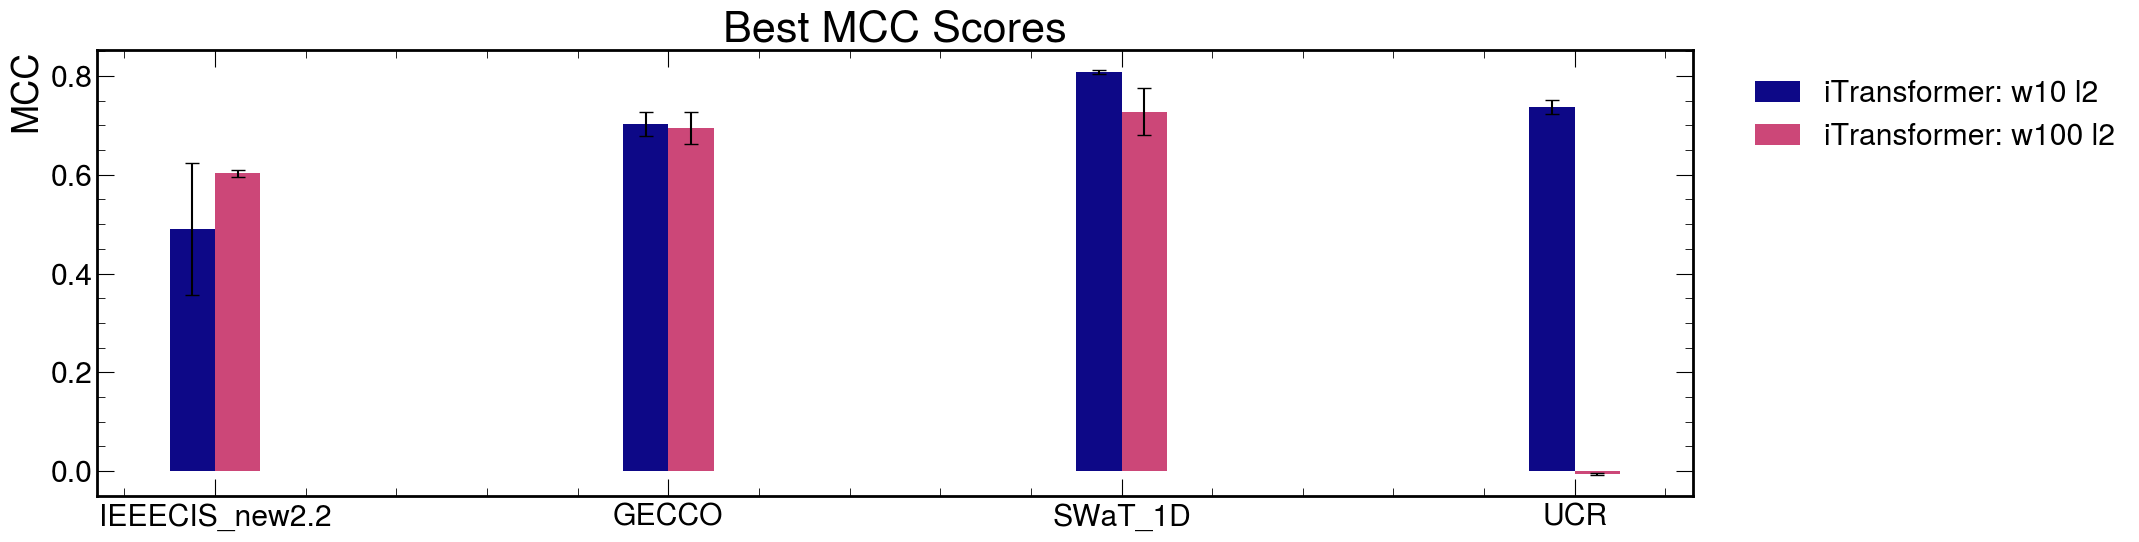

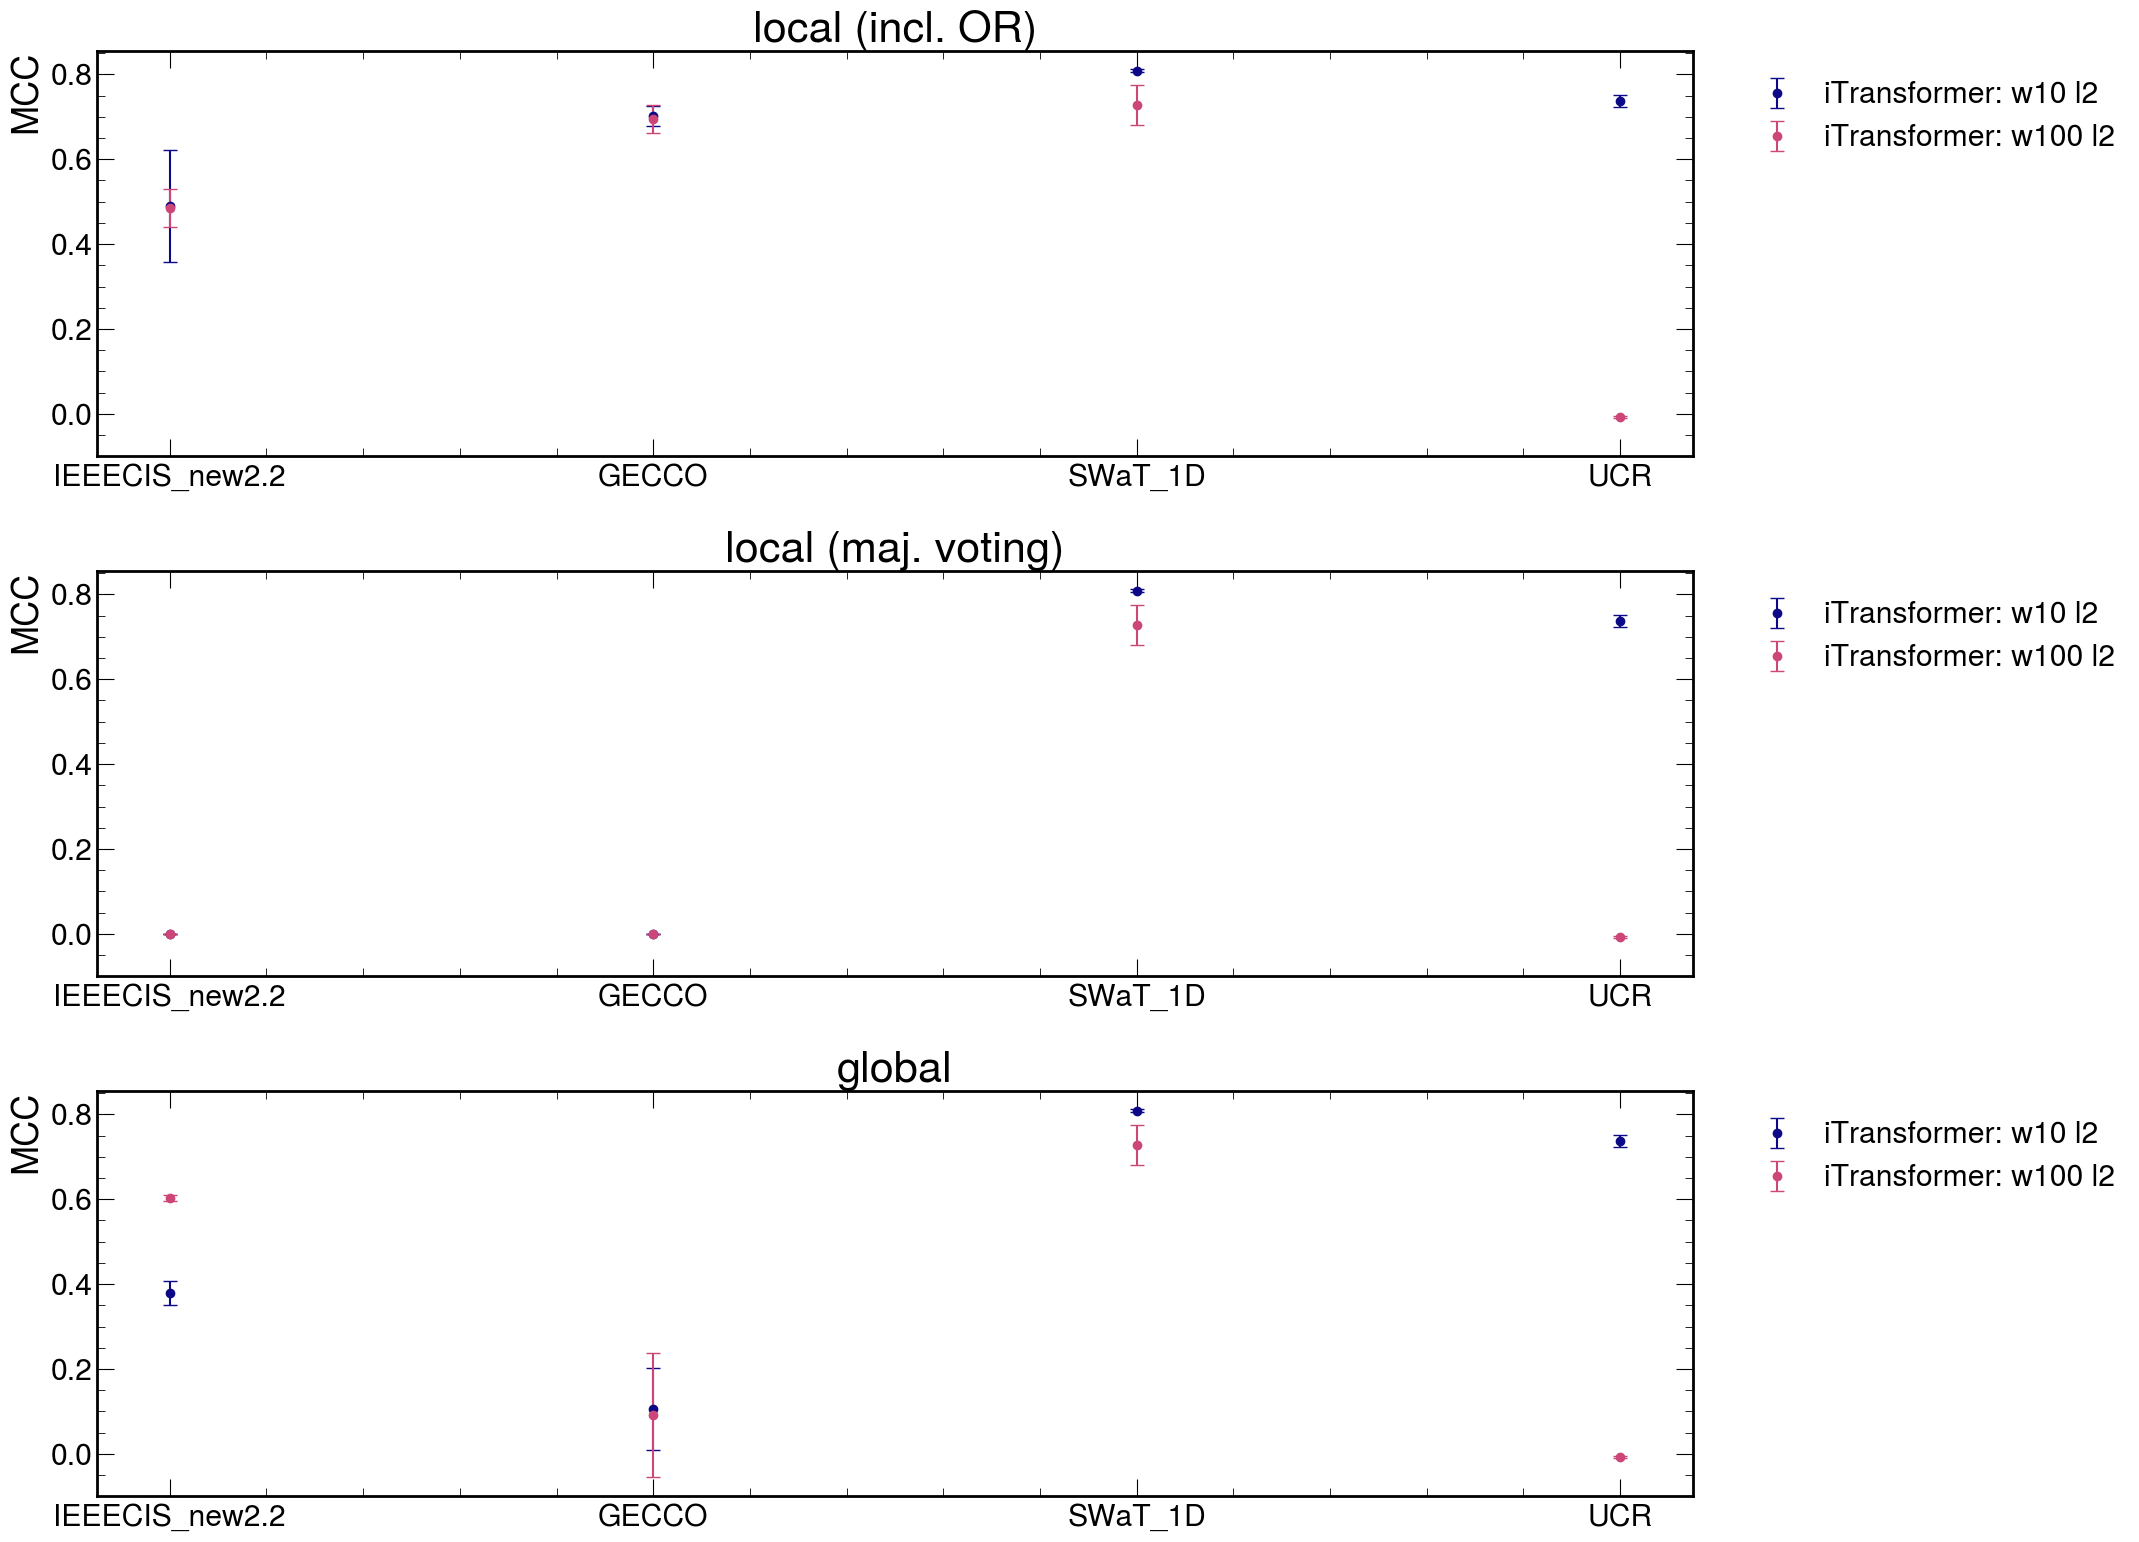

In [51]:
data3 = ['IEEECIS_new2.2', 'GECCO', 'SWaT_1D', 'UCR']
# ['ATLAS_TS', 'IEEECIS_new2.2', 'GECCO6', 'SMD', 'SMAP_new', 'MSL_new', 'SWaT', 'UCR'] #'ATLAS_TS',
models3 = ['iTransformer3', 'iTransformer4']  #'TranAD', 'MAD_GAN', 'OmniAnomaly', 'LSTM_AE', 'DAGMM', 'USAD']
# ['iTransformer3', 'iTransformer5', 'iTransformer7', 'iTransformer10', 'TranAD']
# ['iTransformer4', 'iTransformer8', 'iTransformer6', 'iTransformer9', 'iTransformer11', 'TranAD']
# ['iTransformer3', 'iTransformer5', 'iTransformer7', 'TranAD']
# ['iTransformer4', 'iTransformer8', 'iTransformer6', 'iTransformer9', 'TranAD']
lab = [config[m]['lab'] for m in models3]

name = None  # 'rep5_new_all'
plot_best_scores_mean_std_box(results_mean_std, data3, models3, metric='MCC', labels=lab, name=name)
plot_scores_mean_std_box(results_mean_std, modes, data3, models3, metric='MCC', labels=lab, name=name)
# plot_best_scores_mean_std(results_mean_std, data3, models3, metric='ROC/AUC', labels=lab, name=name)
# plot_scores_mean_std(results_mean_std, modes, data3, models3, metric='ROC/AUC', labels=lab, name=name)  
# plot_best_scores_mean_std(results_mean_std, data3, models3, metric='f1', labels=lab, name=name)  
# plot_scores_mean_std(results_mean_std, modes, data3, models3, metric='f1', labels=lab, name=name) 

In [ ]:
data41 = ['ATLAS_TS', 'IEEECIS_new2.2', 'GECCO6'] 
data42 = ['MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'UCR'] 

models4 = ['iTransformer3', 'iTransformer5', 'iTransformer7', 'iTransformer10', 'TranAD']
# ['iTransformer4', 'iTransformer8', 'iTransformer6', 'iTransformer9', 'TranAD']
lab = [config[m]['lab'] for m in models4]

name41 = 'latent_w10_rep5_3'
name42 = 'latent_w10_rep5_4'

plot_best_MSE_mean_std(results_mean_std, data41, models4, metric='train loss', labels=lab, name=name41) 
plot_best_MSE_mean_std(results_mean_std, data41, models4, metric='test loss', labels=lab, name=name41)  
plot_best_MSE_mean_std(results_mean_std, data42, models4, metric='train loss', labels=lab, name=name42) 
plot_best_MSE_mean_std(results_mean_std, data42, models4, metric='test loss', labels=lab, name=name42) 

In [253]:
def list_results(results, datasets, models, metric='MCC', labels=None, val='mean'):
    dict = {}
    for j, model in enumerate(models):
        mcc_scores = []
        for dataset in datasets:
            key = f'{model}_{dataset}'
            print(key)
            if key in results:
                mcc_scores.append(results[key][val][metric].max().round(3))
            else:
                mcc_scores.append(0)  # If no data, append 0

            dict[labels[j]] = mcc_scores

    return dict

In [ ]:
val = 'mean'
metric = 'train_loss'
namee = 'latent2_rep5_new'
data3 = ['IEEECIS_new2.2', 'GECCO', 'SMD', 'SMAP_new', 'MSL_new','UCR']
# ['ATLAS_TS', 'IEEECIS_new2.2', 'GECCO6', 'SMD', 'SMAP_new', 'MSL_new', 'SWaT', 'UCR'] #'ATLAS_TS',
models3 = ['iTransformer3', 'iTransformer4', 'TranAD']
# ['iTransformer4', 'iTransformer8', 'iTransformer6', 'iTransformer9', 'iTransformer11', 'TranAD']
# ['iTransformer3', 'iTransformer5', 'iTransformer7', 'iTransformer10', 'TranAD']
# ['iTransformer3', 'iTransformer5', 'iTransformer7', 'TranAD']
# ['iTransformer4', 'iTransformer8', 'iTransformer6', 'iTransformer9', 'TranAD']
lab = [config[m]['lab'] for m in models3]

dict_bestMCC = list_results(results_mean_std, data3, models3, metric, labels=lab, val=val)
df_bestMCC = pd.DataFrame(dict_bestMCC, index=data3).T
print(df_bestMCC)
print(df_bestMCC.values)
metric = metric.replace(' ', '_')
# df_bestMCC.to_csv(f'studies_earlystopping/data/best{metric}_{namee}_{val}.csv')

### training and validation loss

In [3]:
import glob

In [20]:
config = {
 'iTransformer1': {'window': 10, 'steps': 1, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w10 l2', 'weighted': False},
 'iTransformer2': {'window': 100, 'steps': 50, 'latent': 2, 'eps': 100, 'lab': 'iTransformer: w100 l2', 'weighted': False},
}


In [23]:
datasets = ['GECCO', 'IEEECIS_new2.2', 'UCR', 'SWaT_1D'] 
models = ['iTransformer1', 'iTransformer2']  # 'TranAD'


all_paths = []
losses = {}
for dataset in datasets:
    for model in models:
        if 'iTransformer' in model and model != 'iTransformer':
            paths = glob.glob(f'iTransformer_results_lxplus/iTransformer_{dataset}')
        else:
            paths = glob.glob(f'{model}_results_lxplus/{model}_{dataset}')
        all_paths.extend(paths)
        if not paths:
            print(f'No paths found for {model} on {dataset}')
        feats = 30 if dataset == 'IEEECIS_new2.2' else -1

        for path in paths:
            if model in config.keys():
                if model == 'TranAD':
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}*feats{feats}*/checkpoints/model_final.ckpt")
                else:
                    res_path = glob.glob(f"{path}/*n_window{config[model]['window']}_steps{config[model]['steps']}_feats{feats}_eps{config[model]['eps']}_latent{config[model]['latent']}_*/checkpoints/model_final.ckpt")
            else:
                res_path = glob.glob(f'{path}/*n_window10_steps1*feats{feats}*/checkpoints/model_final.ckpt')

            if res_path:
                res_path = np.sort(res_path)
                print(model, dataset, len(res_path))
                # print(res_path)
                tmp = pd.DataFrame()
                key = res_path[0].split('/')[1]
                if 'iTransformer' in model and model != 'iTransformer':
                        idx = len('iTransformer')  # len(model) - 1
                        diff = len(model) - len('iTransformer')
                        # insert a number in the key to distinguish between the models at position idx
                        key = key[:idx] + model[-diff:] + key[idx:]
                losses[key] = {'val_loss': [], 'train_loss': []}
                for i, p in enumerate(res_path):
                    model = torch.load(p)
                    accuracy_list = model['accuracy_list']
                    lossT = [i[0] for i in accuracy_list]
                    lossV = [i[1] for i in accuracy_list] 
                    losses[key]['val_loss'].append(lossV)
                    losses[key]['train_loss'].append(lossT)
            else:
                print(f'No results found for {model} on {dataset}')

print(losses.keys())
# print(len(losses['iTransformer_GECCO']['val_loss']), len(losses['iTransformer_GECCO']['val_loss'][0]))

iTransformer1 GECCO 5
iTransformer2 GECCO 5
iTransformer1 IEEECIS_new2.2 5
iTransformer2 IEEECIS_new2.2 5
iTransformer1 UCR 5
iTransformer2 UCR 5
iTransformer1 SWaT_1D 5


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_20037/4114296109.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(p)
/var/folders/mz/8xvqd9

iTransformer2 SWaT_1D 5
dict_keys(['iTransformer1_GECCO', 'iTransformer2_GECCO', 'iTransformer1_IEEECIS_new2.2', 'iTransformer2_IEEECIS_new2.2', 'iTransformer1_UCR', 'iTransformer2_UCR', 'iTransformer1_SWaT_1D', 'iTransformer2_SWaT_1D'])


/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_20037/4114296109.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(p)


In [24]:
from cycler import cycler
current_cycler = plt.rcParams['axes.prop_cycle']
print(current_cycler)

cycler('color', ['#5790fc', '#f89c20', '#e42536', '#964a8b', '#9c9ca1', '#7a21dd'])


In [29]:
# Plot training and validation losses
def plot_losses(losses, dataset):
    # colors = current_cycler.by_key()['color']
    colors = plt.cm.viridis(np.linspace(0, 1, 5))

    for key in losses.keys():
        if dataset in key:
            print(key)
            train_losses = losses[key]['train_loss']
            val_losses = losses[key]['val_loss']
            for i in range(len(train_losses)):
                plt.plot(train_losses[i], '-o', label=f'Train Loss {i+1}-fold', color=colors[i])
                plt.plot(val_losses[i], '-*', label=f'Val Loss {i+1}-fold', color=colors[i])
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'Losses for TranAD on {dataset}')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'./studies_results_lxplus/{key}_losses.png', facecolor='w')
            plt.show()


iTransformer1_GECCO


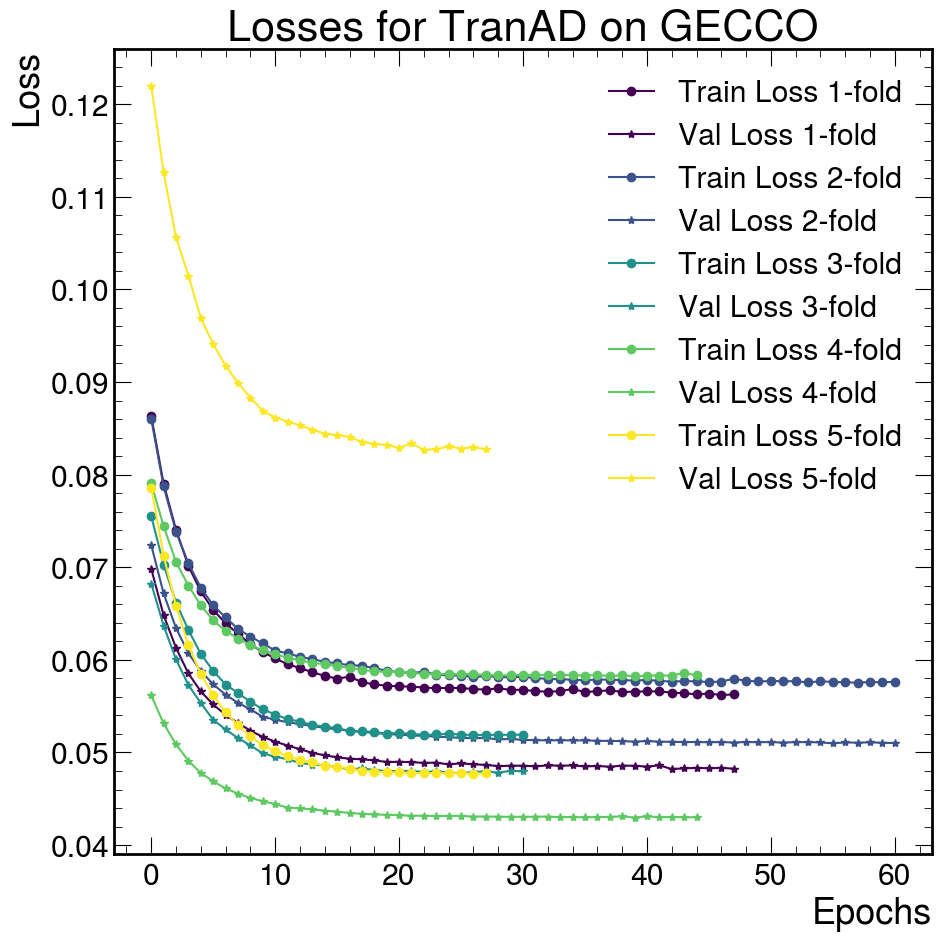

iTransformer2_GECCO


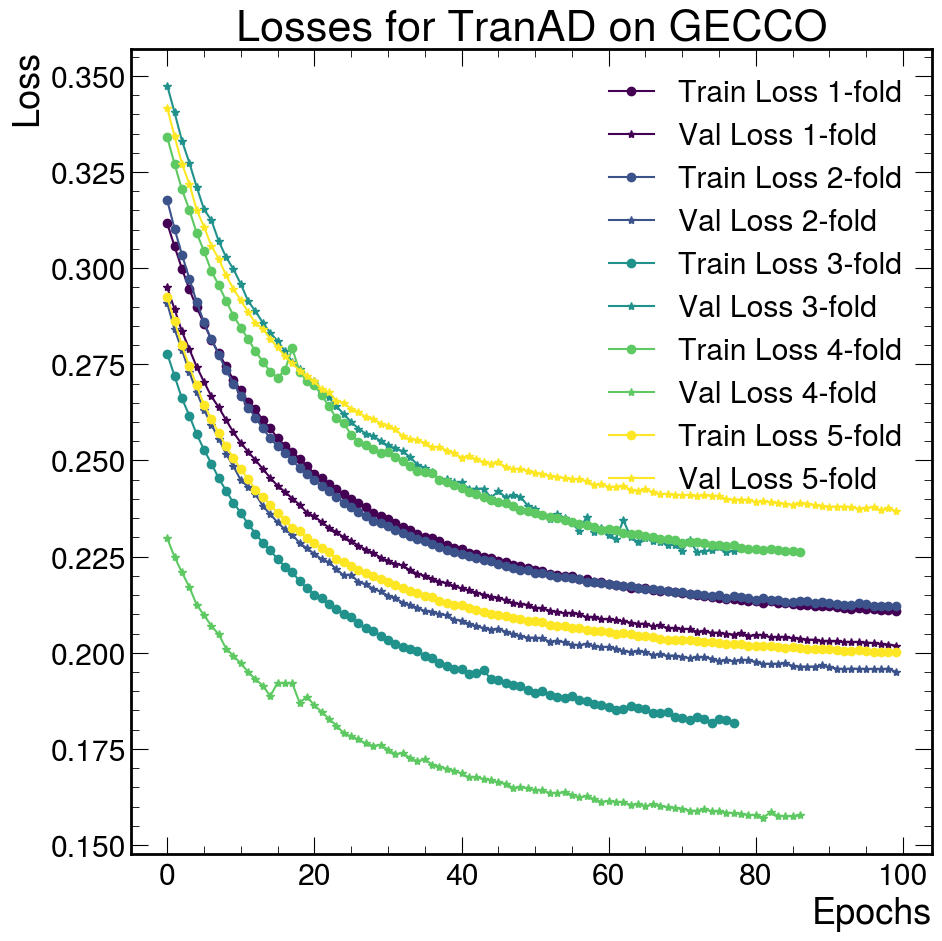

iTransformer1_IEEECIS_new2.2


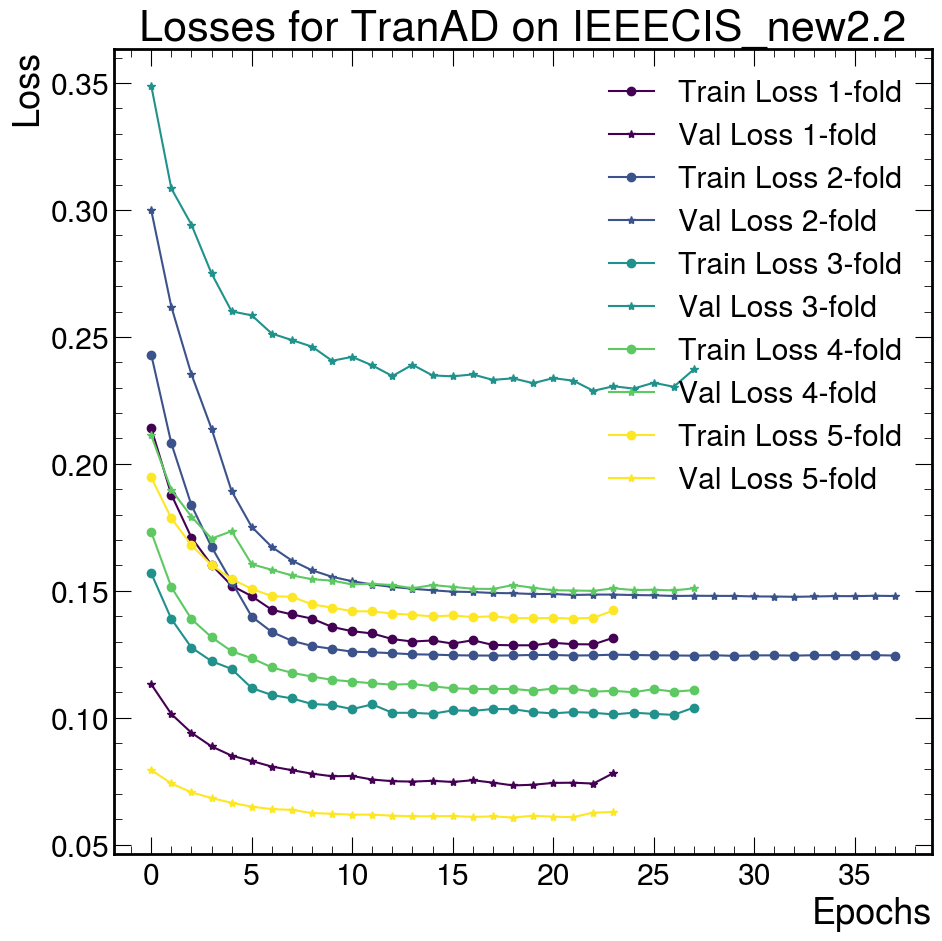

iTransformer2_IEEECIS_new2.2


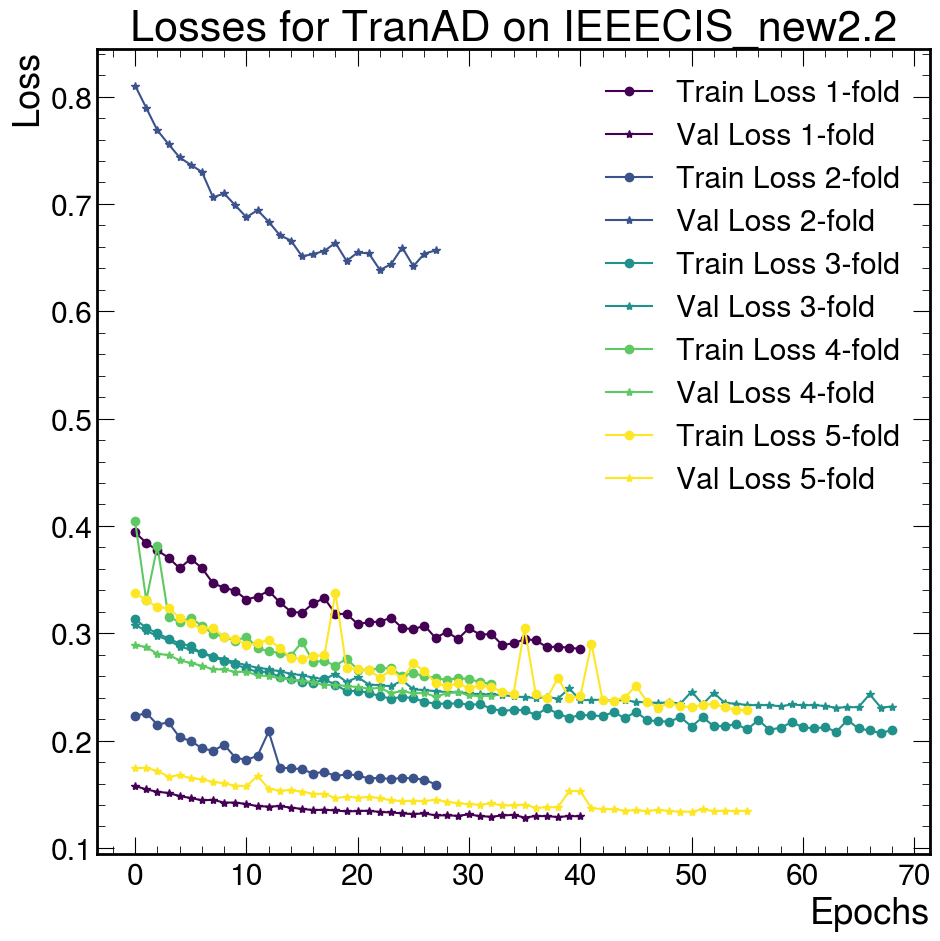

iTransformer1_UCR


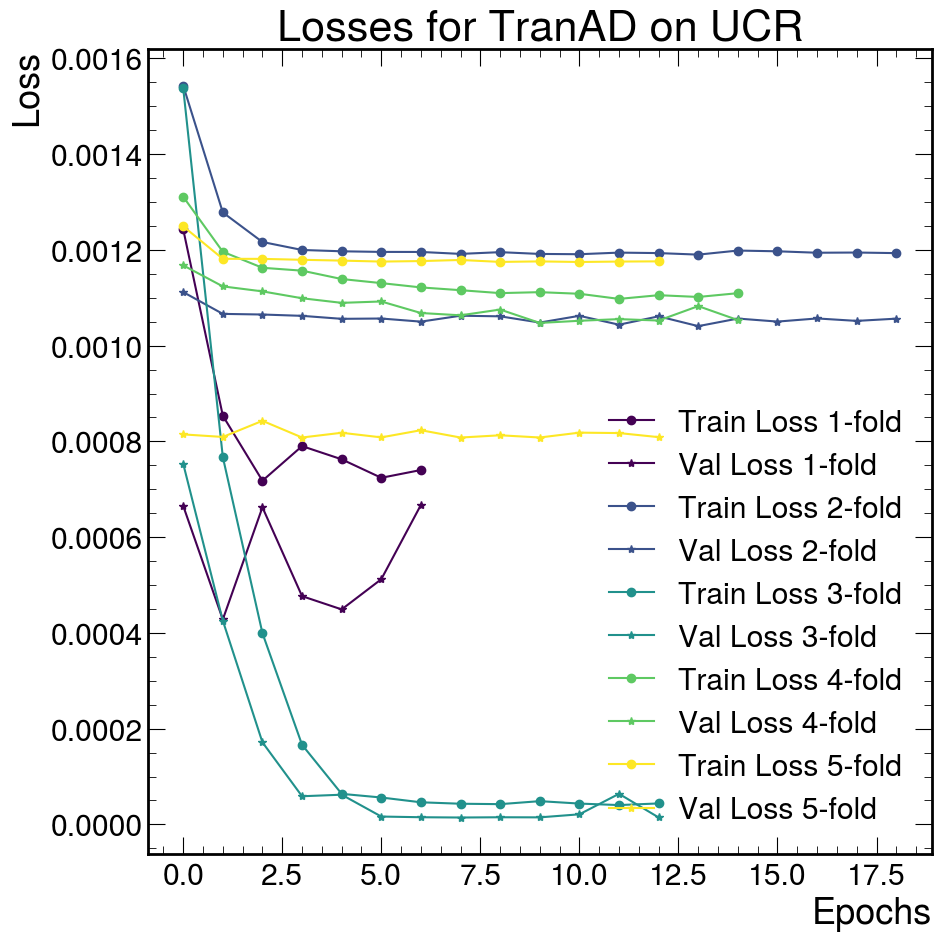

iTransformer2_UCR


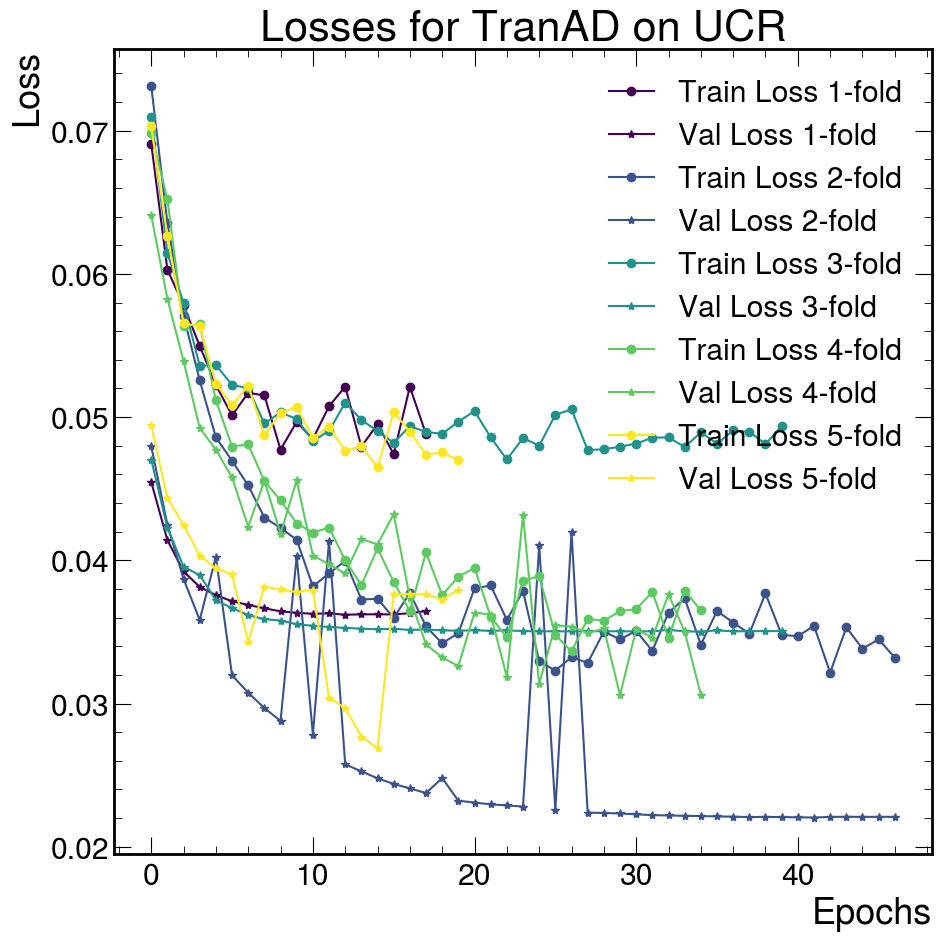

iTransformer1_SWaT_1D


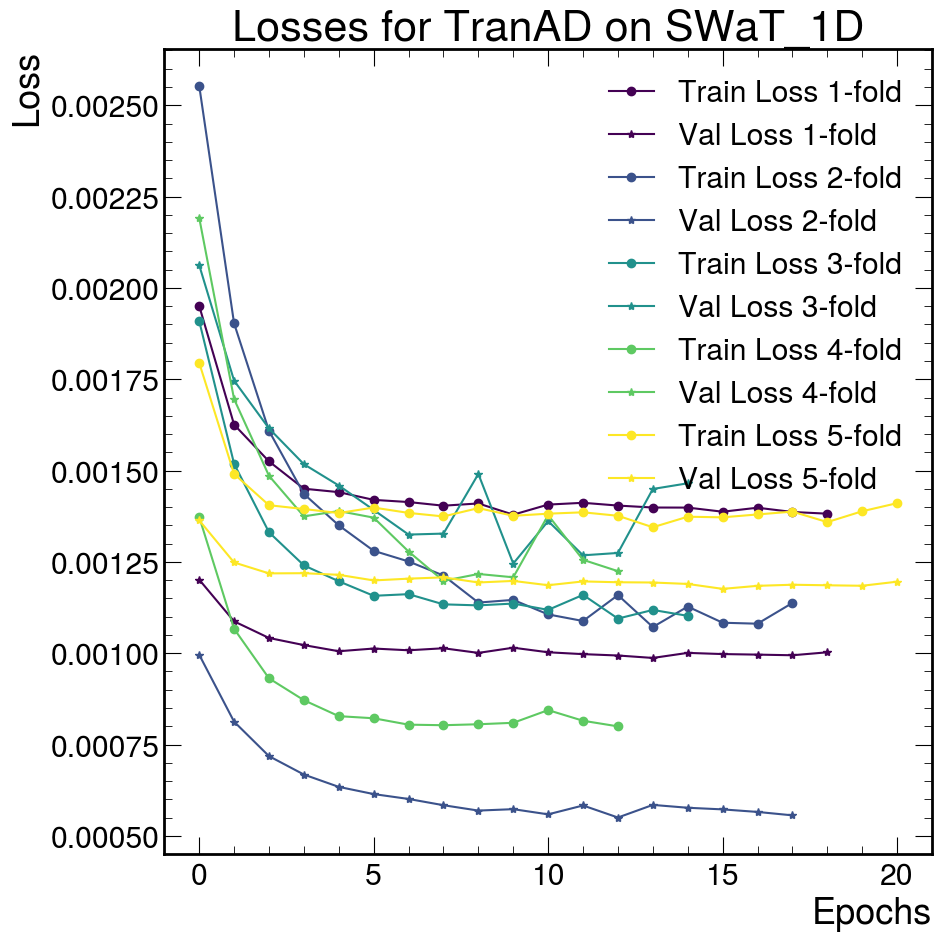

iTransformer2_SWaT_1D


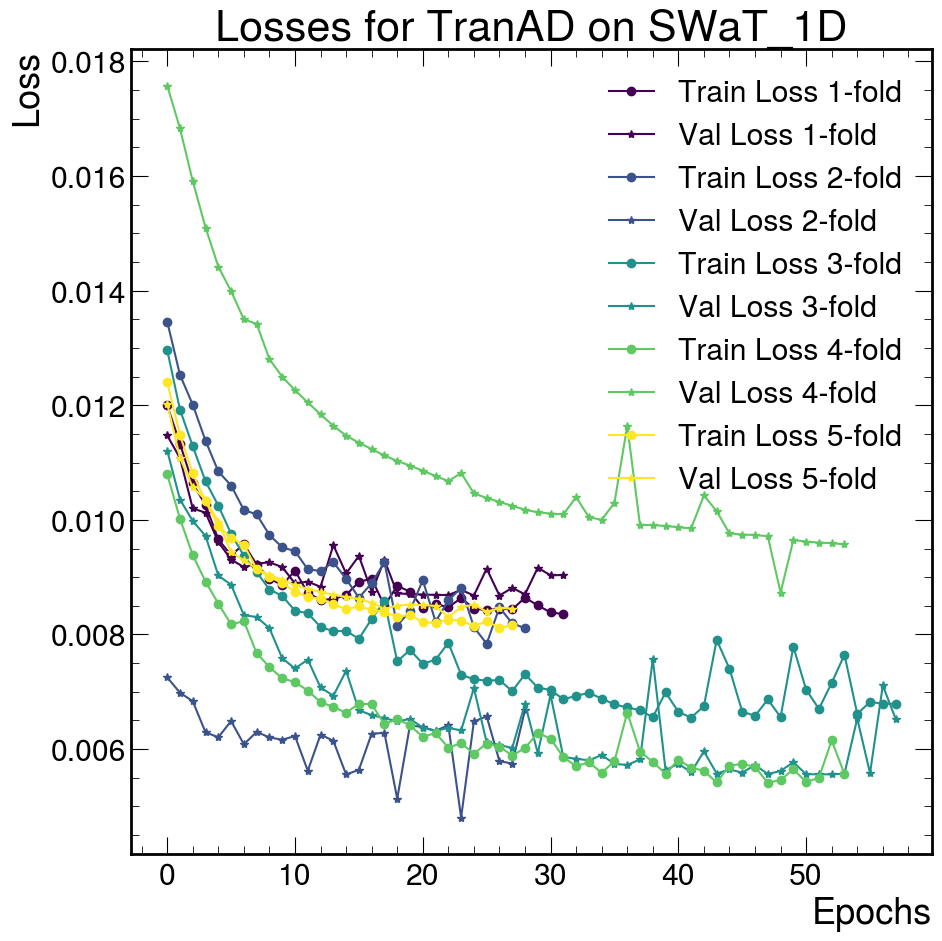

In [30]:
# Usage
for dataset in datasets:
    plot_losses(losses, dataset)